In [11]:
import os
os.environ['DEVELOPMENT'] = 'True'
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent, IrrigationManagement, GroundWater, FieldMngt
from aquacrop.utils import prepare_weather, get_filepath



# Main mismatches

AQ-Py and AQ-Win do not currently match well for v7:

* First year yield and biomass is zero for all of exercise 7 and exercise 8.2 (rest of 8 and all of 9 unaffected - ?!)

## Setup comparison function

### Remove headers fn

In [12]:
# drop rows that contain repetitions of the headers throughout the file, one per successive annual run
def remove_headers(data):
    start_points=data[data.isin(['Day']).any(axis=1)].index # begin row drops where 'Day' is in any col
    end_points = [x+3 for x in start_points] # end 3 lines later
    to_drop=[]
    n=0

    while(n < len(start_points)):
        x=list(range(start_points[n]-1, end_points[n]-1)) # adjust drops, one line before the indexes found previously
        to_drop.extend(x) # add all indexes to drop to a list
        n=n+1

    new_data = data.drop(index=to_drop)

    return new_data

### Extract py data fn

In [13]:
def extract_py_data(py_model):
    py_growth=py_model.get_crop_growth()
    py_wflux=py_model.get_water_flux()
    #py_wstorage=py_model.get_water_storage()

    start_year=py_model.sim_start_time.split('/')[0]
    start_month,start_day=py_model.crop.planting_date.split('/')

    py_growth['datetime']=py_growth.apply(lambda x:datetime.datetime(int(x['season_counter']+int(start_year)),int(start_month),int(start_day)+1)+datetime.timedelta(int(x['dap']-1)),axis=1)
    py_wflux['datetime']=py_wflux.apply(lambda x:datetime.datetime(int(x['season_counter']+int(start_year)),int(start_month),int(start_day)+1)+datetime.timedelta(int(x['dap']-1)),axis=1)

    py_growth.drop(['dap','time_step_counter','season_counter'], inplace=True,axis=1)
    py_wflux.drop(['dap','time_step_counter','season_counter'], inplace=True,axis=1)

    py_outputs=pd.merge(py_growth, py_wflux, on='datetime')
    py_outputs['source']='AQ-Py'
    py_outputs.rename(columns={
            'yield_': 'dry_yield',
            # 'Month': 'month',
            # 'Day': 'day',
            },
            inplace=True, 
            errors='raise')

    return py_outputs

    

### Extract Win data fn

In [14]:
def extract_win_data(proj_name):

    file_list=['Crop','Wabal','Prof','Clim'] # ,'CompWC'
    data=[]

    for i in range(0,len(file_list)):
        file_type=file_list[i]
        path='C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+proj_name+file_type+'.OUT'
        if file_type=='Crop':
            temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=33)
        elif file_type=='Wabal':
            temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=27)
            temp=temp.drop(['Tr', 'Trx','Tr/Trx', 'WCTot','Rain'],axis=1)
        elif file_type=='Prof':
            temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=19, index_col=False)
            temp=temp.drop(['Z'],axis=1)
        #elif file_type=='CompWC':
        #    temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=5, skipfooter=9)
        elif file_type=='Clim':
            temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=15)
        
        #if file_type != 'CompWC':
        temp=temp.drop([0])
        
        temp.rename(columns={
            'Year': 'year',
            'Month': 'month',
            'Day': 'day',
            },
            inplace=True, 
            errors='raise'
        )
        temp=remove_headers(temp)
        # add datetime column
        temp['datetime'] = pd.to_datetime(temp[['year','month','day']])
        # convert all cols except date-related cols to floats
        cols=temp.columns.drop(['day','month','year','datetime'])
        temp[cols]=temp[cols].apply(pd.to_numeric, errors='coerce')
        temp=temp.drop(['year','month','day','DAP','Stage'], axis=1)
        data.append(temp)

    temp1=pd.merge(data[0],data[1], on='datetime')
    temp2=pd.merge(temp1,data[2], on='datetime')
    win_data=pd.merge(temp2,data[3], on='datetime')
    #win_data=pd.merge(temp3,data[4], on='datetime')   
    
    # rename cols to align with py col names
    win_data.rename(columns={'CC': 'canopy_cover',
                            'Y(dry)': 'dry_yield',
                            'Biomass': 'biomass',
                            'HI':'harvest_index',
                            'Z':'z_root',
                            },
                    inplace=True, errors='raise'
                    )
    win_data['harvest_index']=win_data['harvest_index']/100
    win_data['canopy_cover']=win_data['canopy_cover']/100
    win_data['biomass']=win_data['biomass']*100
    
    win_data['source']='AQ-Win'

    return win_data
    # Crop: daily crop growth: 4, 33

    # Wabal: daily water balance: 4,27

    # Prof: daily soil-water content in soil profile (WC) and root zone (Wr): 4,19

    # CompWC: daily soil-water content at various depths: 4,9

    # Clim: climate input data: 4,15

### Create datetime

In [15]:
def get_datetime(df, start_year, start_month, start_day):    
    df['year']=df['season_counter'].astype(int)+int(start_year)
    df['combined']=df['year'].astype(str) + ' ' + str(start_month) + ' ' + str(start_day)
    df['start_date']=pd.to_datetime(df['combined'], format='%Y %m %d')
    df['dap-1']=df['dap']-1
    df['time_added']=pd.to_timedelta(df['dap-1'], 'd')
    df['datetime']=df['start_date'] + df['time_added']
    # df.drop(['combined','start_date','start_doy','doy_dap','time_added'],axis=1, inplace=True)
    df=df[(df['dap-1'] >= 0)] # dap starts at 0, anything below 0 is NA
    return(df)

# Run comparison fn

In [40]:
def run_comparison(win_filename, py_model):

    # Get Python daily output
    py_daily_outputs = py_model.get_crop_growth()
    # py_daily_outputs.rename(columns={'biomass':'biomass_old','canopy_cover':'canopy_cover_old'}, inplace=True) # 'biomass':'biomass_old',
    py_daily_outputs['biomass']=py_daily_outputs['biomass']/100
    # print(py_daily_outputs.columns)
    py_daily_outputs['canopy_cover']=py_daily_outputs['canopy_cover']*100
    # PY GROWTH COLS = ['time_step_counter', 'season_counter', 'dap', 'gdd', 'gdd_cum',
    #    'z_root', 'canopy_cover', 'canopy_cover_ns', 'biomass', 'biomass_ns',
    #    'harvest_index', 'harvest_index_adj', 'DryYield', 'FreshYield',
    #    'YieldPot']

    py_daily_water=py_model.get_water_flux()
    # PY WATER COLS = ['time_step_counter', 'season_counter', 'dap', 'Wr', 'z_gw',
    #    'surface_storage', 'IrrDay', 'Infl', 'Runoff', 'DeepPerc', 'CR', 'GwIn',
    #    'Es', 'EsPot', 'Tr', 'TrPot']

    start_year=int(py_model.sim_start_time.split('/')[0])
    start_month,start_day=py_model.crop.planting_date.split('/')

    py_daily_outputs=get_datetime(py_daily_outputs, start_year,start_month,start_day)

    py_daily_water=get_datetime(py_daily_water, start_year,start_month,start_day)
    
    # py_daily_outputs.to_csv('py_daily_outputs.csv', index = False, encoding='utf-8')
    # py_daily_water.to_csv('py_daily_water.csv', index = False, encoding='utf-8')
    py_outputs=pd.merge(py_daily_outputs, py_daily_water, on='datetime')

    py_outputs['source']='AQ-Py'

    # Get Python annual outputs
    py_annual_outputs = py_model._outputs.final_stats.round(3)
    #py_annual_outputs.columns = ["Season","CropType","datetime","HarvestDate (Step)","dry_yield", "fresh_yield","yield_potential", "Seasonal irrigation (mm)"]
    py_annual_outputs.columns = ["Season","CropType","datetime","HarvestDate (Step)","dry_yield", "Seasonal irrigation (mm)"]
    py_annual_outputs['source']='Py'

    # Get windows daily outputs (CROP)
    win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT', 
                            skiprows=4, skipfooter=33,  delim_whitespace=True,encoding="latin1")
    # WIN DAILY CROP COLS = ['Day', 'Month', 'Year', 'DAP', 'Stage', 'GD', 'Z', 'StExp', 'StSto',
    #    'StSen', 'StSalt', 'StWeed', 'CC', 'CCw', 'StTr', 'Kc(Tr)', 'Trx', 'Tr',
    #    'TrW', 'Tr/Trx', 'WP', 'Biomass', 'HI', 'Y(dry)', 'Y(fresh)',
    #    'Brelative', 'WPet', 'Bin', 'Bout']
    win_daily_outputs=win_daily_outputs.drop([0])
    win_daily_outputs.rename(columns={
        'Year': 'year',
        'Month': 'month',
        'Day': 'day',
        },
        inplace=True, 
        errors='raise')
    win_daily_outputs=remove_headers(win_daily_outputs)

    # Get windows daily water outputs (WABAL)
    win_daily_water = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'WABAL.OUT', 
                            skiprows=4, skipfooter=33,  delim_whitespace=True,encoding="latin1")
     # WIN DAILY WABAL COLS = ['Day', 'Month', 'Year', 'DAP', 'Stage', 'WCTot', 'Rain', 'Irri', 'Surf',
    #    'Infilt', 'RO', 'Drain', 'CR', 'Zgwt', 'Ex', 'E', 'E/Ex', 'Trx', 'Tr',
    #    'Tr/Trx', 'ETx', 'ET', 'ET/ETx']
    win_daily_water=win_daily_water.drop([0])
    win_daily_water.rename(columns={
        'Year': 'year',
        'Month': 'month',
        'Day': 'day',
        },
        inplace=True, 
        errors='raise')
    win_daily_water=remove_headers(win_daily_water)
    win_daily_water.drop(['Tr'],axis=1,inplace=True) # remove Tr because it's a duplicate of win_daily_outputs version

    def line_fixer(x):
        if not x[0].isnumeric() and x[-1].isnumeric():
            return x[1:] 
        
        if not x[-1].isnumeric() and x[0].isnumeric():
            return x[:-1]
        
        return None

    # Get windows daily soil profile outputs (Prof)
    win_daily_profile = pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Prof.OUT', 
                            skiprows=4, skipfooter=20,  delim_whitespace=True, encoding="latin1", on_bad_lines=line_fixer, engine='python')
     # WIN DAILY PROFILE COLS = ['Day', 'Month', 'Year', 'DAP', 'Stage', 'WCTot', 'Wr(Zx)', 'Z', 'Wr',
    #    'Wr(SAT)', 'Wr(FC)', 'Wr(exp)', 'Wr(sto)', 'Wr(sen)', 'Wr(PWP)']
    win_daily_profile=win_daily_profile.drop([0])
    win_daily_profile.rename(columns={
        'Year': 'year',
        'Month': 'month',
        'Day': 'day',
        },
        inplace=True, 
        errors='raise')
    win_daily_profile=remove_headers(win_daily_profile)
    # win_daily_profile.to_csv('win_daily_profile.csv', index = False, encoding='utf-8')
    # print(win_daily_water.columns)
    win_daily_profile.drop(['Z'],axis=1,inplace=True) # remove Z because it's a duplicate of win_daily_outputs version

    # add datetime columns
    win_daily_outputs['datetime'] = pd.to_datetime(win_daily_outputs[['year','month','day']])
    win_daily_water['datetime'] = pd.to_datetime(win_daily_water[['year','month','day']])
    win_daily_profile['datetime'] = pd.to_datetime(win_daily_profile[['year','month','day']])

    # convert all cols except date-related cols to floats
    cols=win_daily_outputs.columns.drop(['day','month','year','datetime'])
    cols_water=win_daily_water.columns.drop(['day','month','year','datetime'])
    cols_profile=win_daily_profile.columns.drop(['day','month','year','datetime'])

    win_daily_outputs[cols]=win_daily_outputs[cols].apply(pd.to_numeric, errors='coerce')
    win_daily_water[cols_water]=win_daily_water[cols_water].apply(pd.to_numeric, errors='coerce')
    win_daily_profile[cols_profile]=win_daily_profile[cols_profile].apply(pd.to_numeric, errors='coerce')
    print(win_daily_outputs.columns)

    win_temp=pd.merge(win_daily_outputs,win_daily_water,on='datetime')
    print(win_temp.columns)
    win_outputs=pd.merge(win_temp,win_daily_profile, on='datetime')
    print(win_outputs.columns)
    # rename cols to align with py col names
    win_outputs.rename(columns={'CC': 'canopy_cover',
                                'Y(dry)': 'Yield',
                                'Biomass': 'biomass',
                                'HI':'harvest_index',
                                'Zgwt':'z_gw',
                                'Infilt':'Infl',
                                'Z':'z_root'
                                },
                    inplace=True, errors='raise')
    win_outputs['harvest_index']=win_outputs['harvest_index']/100
    win_outputs['source']='AQ-Win'

    # Get windows annual outputs
    win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT', 
                                skiprows=4, skipfooter=8,  delim_whitespace=True,encoding="ISO-8859-1")
    win_annual_outputs=win_annual_outputs.drop([0])
    win_annual_outputs=remove_headers(win_annual_outputs)
    win_annual_outputs = win_annual_outputs.iloc[: , :-5] # remove 5 blank cols due to reading error
    win_annual_outputs['datetime']=pd.to_datetime(win_annual_outputs[['Year','Month','Day']])
    win_annual_outputs.columns=['Nr','Day','Month','Year','biomass','dry_yield','fresh-yield', 'datetime']
    win_annual_outputs=win_annual_outputs[win_annual_outputs['Nr'] != '0'] # remove blank rows
    win_annual_outputs['source']='Win'
    # Combine annual outputs
    combined_annual=pd.concat([win_annual_outputs, py_annual_outputs])
    combined_annual['dry_yield']=combined_annual['dry_yield'].astype(float)

    # manipulating for specific plot
    temp_a = py_outputs[['datetime', 'Wr']]
    temp_a.rename(columns={'Wr' : 'Py_Wr'}, inplace=True)
    temp_b = win_outputs[['datetime', 'Wr']]
    temp_b.rename(columns={'Wr' : 'Win_Wr'}, inplace=True)
    temp_c = pd.merge(temp_a, temp_b, on='datetime', how='left')
    temp_d = temp_c['Py_Wr'].sub(temp_c['Win_Wr'])
    print(temp_d.columns)
    # sns.lineplot(data=temp_d, x='datetime', y=)
    # sns.lineplot(data=win_outputs, x='datetime', y='Cr')
    # plt.show()

    # Combine daily outputs
    both_daily_outputs=pd.concat([win_outputs, py_outputs])
    both_daily_outputs=both_daily_outputs[both_daily_outputs['datetime'] < '2001-12-31']
    # fig,ax=plt.subplots(2,2, figsize=(16,10))
    g1=sns.scatterplot(data=both_daily_outputs, x='datetime',y='canopy_cover', hue='source') # , ax=ax[0,0]
    sns.move_legend(g1,'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    #g.set_yticks(range(0,110,10), labels=range(0,110,10)) 
    g2=sns.lineplot(data=both_daily_outputs, x='datetime',y='biomass', hue='source')#, ax=ax[1,0]
    # sns.move_legend(g2,'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    g3=sns.lineplot(data=both_daily_outputs, x='datetime',y='harvest_index', hue='source')#, ax=ax[0,1]
    # sns.move_legend(g3,'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    g4=sns.lineplot(data=both_daily_outputs, x='datetime',y='Tr', hue='source')#, ax=ax[1,1]
    # sns.move_legend(g4,'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    g5=sns.lineplot(data=both_daily_outputs, x='datetime',y='z_gw', hue='source')
    plt.show()
    g6=sns.lineplot(data=both_daily_outputs, x='datetime',y='CR', hue='source')
    plt.show()
    g7=sns.lineplot(data=both_daily_outputs, x='datetime',y='Infl', hue='source')
    plt.show()
    g8=sns.lineplot(data=both_daily_outputs, x='datetime',y='Wr', hue='source')
    plt.show()
    g9=sns.lineplot(data=both_daily_outputs, x='datetime',y='z_root', hue='source')
    plt.show()
    g10=sns.lineplot(data=combined_annual.reset_index(), x='datetime', y='dry_yield', hue='source')
    # sns.move_legend(g5, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    
    #all_daily_outputs=[py_model.get_crop_growth(), py_model.get_water_flux(), py_model.get_water_storage(), win_daily_outputs]

    #return all_daily_outputs

SyntaxError: invalid syntax (1846090530.py, line 153)

## Simple Comparison Fn

In [17]:
def simple_cf(win_file, py_model):

    start_year=int(py_model.sim_start_time.split('/')[0])
    start_month,start_day=py_model.crop.planting_date.split('/')

    # py daily growth
    py_daily_growth=py_model.get_crop_growth()
    # PY GROWTH COLS = ['time_step_counter', 'season_counter', 'dap', 'gdd', 'gdd_cum',
    #    'z_root', 'canopy_cover', 'canopy_cover_ns', 'biomass', 'biomass_ns',
    #    'harvest_index', 'harvest_index_adj', 'DryYield', 'FreshYield',
    #    'YieldPot']
    py_daily_growth['source']='Py'
    # g_tsc=py_daily_growth.time_step_counter
    # g_sc=py_daily_growth.season_counter
    # g_dap=py_daily_growth.dap

    # py daily water
    py_daily_water=py_model.get_water_flux()
    # PY WATER COLS = ['time_step_counter', 'season_counter', 'dap', 'Wr', 'z_gw',
    #    'surface_storage', 'IrrDay', 'Infl', 'Runoff', 'DeepPerc', 'CR', 'GwIn',
    #    'Es', 'EsPot', 'Tr', 'TrPot']
    # w_tsc=py_daily_water.time_step_counter
    # w_sc=py_daily_water.season_counter
    # w_dap=py_daily_water.dap
    py_daily_water['source']='Py'
    # print(g_tsc==w_tsc)
    # print(g_sc==w_sc)
    # print(g_dap==w_dap)

    # win daily growth & water
    win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_file+'Crop.OUT', 
                            skiprows=4, skipfooter=33,  delim_whitespace=True,encoding="latin1")
    win_daily_outputs=win_daily_outputs.drop([0]) # remove starting line, tested with skiprows 5 and didn't work?

    # # remove internal headers within the output text file
    win_daily_outputs=remove_headers(win_daily_outputs).reset_index()
    # WIN COLS = ['Day', 'Month', 'Year', 'DAP', 'Stage', 'GD', 'Z', 'StExp', 'StSto',
    #    'StSen', 'StSalt', 'StWeed', 'CC', 'CCw', 'StTr', 'Kc(Tr)', 'Trx', 'Tr',
    #    'TrW', 'Tr/Trx', 'WP', 'Biomass', 'HI', 'Y(dry)', 'Y(fresh)',
    #    'Brelative', 'WPet', 'Bin', 'Bout']

    # edit win output to match py output
    win_daily_outputs['season_counter']=win_daily_outputs['Year'].astype(int)-start_year
    win_daily_outputs.rename(columns={'DAP':'dap',
                                      'Biomass':'biomass',
                                      'CC':'canopy_cover',
                                      'Y(dry)':'DryYield'}, inplace=True)
    win_daily_outputs['source']='Win'

    win_daily_outputs['dap']=win_daily_outputs['dap'].astype(float)
    win_daily_outputs['dap']=win_daily_outputs['dap'] * 2
    # combined_temp=py_daily_growth.merge(win_daily_outputs, on=['season_counter', 'dap'], how='inner')
    # combined=combined_temp.merge(py_daily_water, on=['season_counter', 'dap'], how='inner')
    # print(len(py_daily_growth.index))
    # print(len(py_daily_water.index))
    # combined_temp=py_daily_growth.merge(py_daily_water, on=['season_counter','dap'])
    # combined_temp['source']='Py'
    # print(len(combined_temp.index))
    # print(len(win_daily_outputs.index))
    # combined=pd.concat([combined_temp, win_daily_outputs])
    # print(len(combined.index))

    growth_cf=pd.concat([py_daily_growth, win_daily_outputs])

    water_cf=pd.concat([py_daily_water, win_daily_outputs])
    # combined.to_csv('combined.csv', index = False, encoding='utf-8')

    # tr_data=pd.DataFrame([py_daily_water.Tr, win_daily_outputs.Tr]).T
    # tr_data.columns=['Py','Win']
    # bm_data=pd.DataFrame([py_daily_growth.biomass, win_daily_outputs.Biomass]).T
    # bm_data.columns=['Py','Win']
    # cc_data=pd.DataFrame([py_daily_growth.canopy_cover, win_daily_outputs.CC]).T
    # cc_data.columns=['Py','Win']
    # yd_data=pd.DataFrame([py_daily_growth.DryYield, win_daily_outputs['Y(dry)']]).T
    # yd_data.columns=['Py','Win']
    
    # print('TR:')
    # print(tr_data.head())
    # tr_data['Win']=tr_data['Win'].astype(float)
    # print('BM:')
    # print(bm_data.head())

    # print('CC:')
    # print(cc_data.head())

    # print('YD:')
    # print(yd_data.head())

    fig,ax=plt.subplots(2,2,sharex=True,figsize=(11,8))
    growth_cf=growth_cf.reset_index()
    g1=sns.lineplot(data=growth_cf, x=growth_cf.index,y='canopy_cover', hue='source', ax=ax[0,0]) # , ax=ax[0,0]
    # ax[0,0].plot(tr_data.Py, label='Py')
    # ax[0,0].plot(tr_data.Win, label='Win')

    plt.show()

# GW Exercise

# Exercise 7

## Exercise 7.1 with Tunis Local soil

In [9]:
# Tunis climate
filepath=get_filepath('tunis_climate.txt')
tunis_weather = prepare_weather(filepath)

# Local Tunis soil
tunis_soil = Soil(soil_type='ac_TunisLocal')

# crops
wheat = Crop('WheatGDD', planting_date='10/15')

# IWC
wet_dry = InitialWaterContent(wc_type='Num',
                              method='Depth',
                              depth_layer=[0.3,0.9],
                              value=[0.3,0.15])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/03/24',
                      weather_df=tunis_weather,
                      soil=tunis_soil,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=wet_dry,
                      )
model.run_model(till_termination=True)

# outputs=run_comparison('Tun_WW_LocalSoil', model)

True

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_16968\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_16968\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


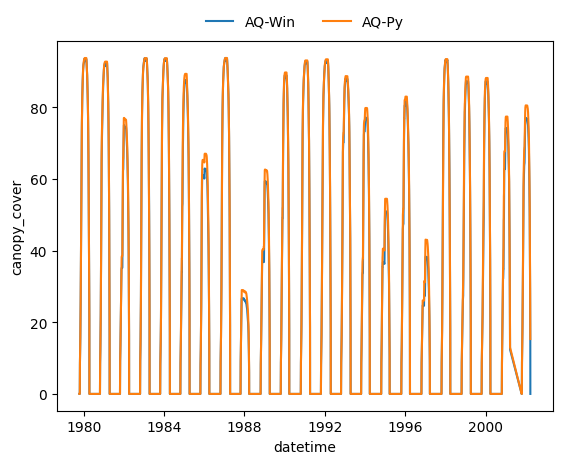

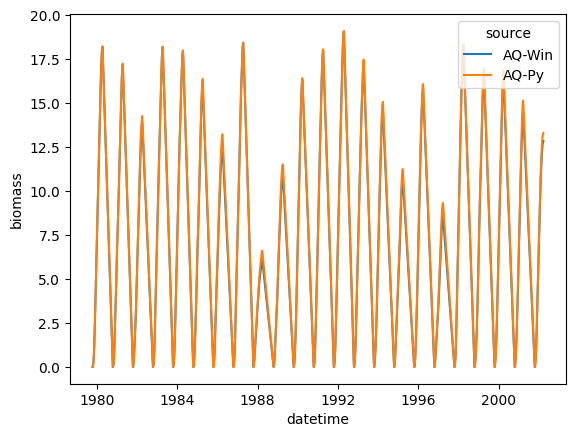

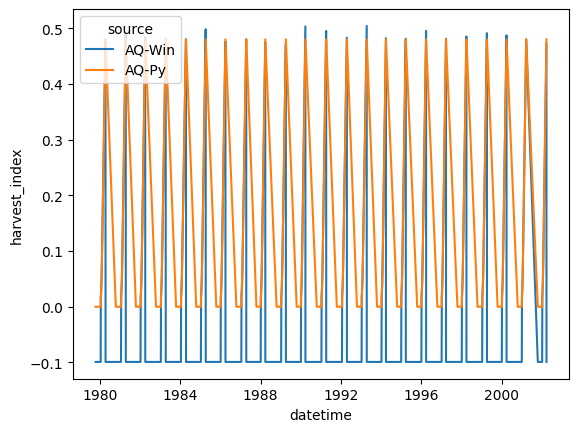

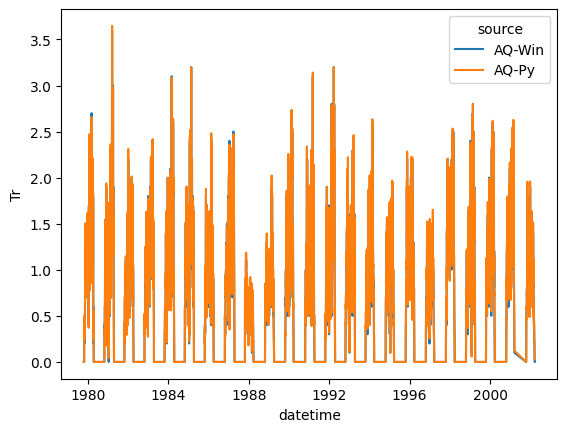

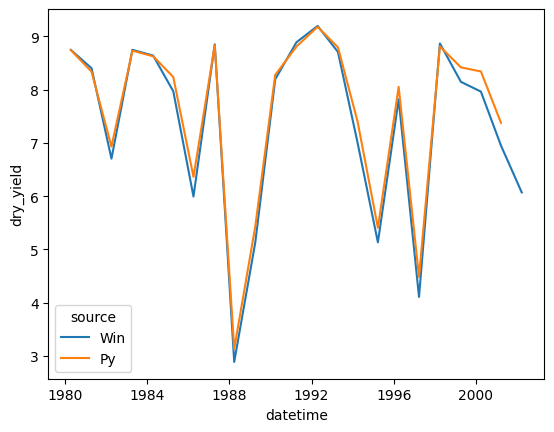

In [10]:
run_comparison('Tun_WW_LocalSoil',model)

### Exercise 7.1 with Sandy Loam

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_16968\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_16968\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


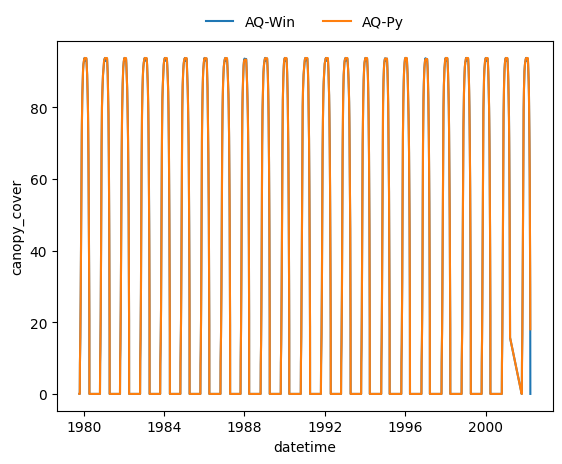

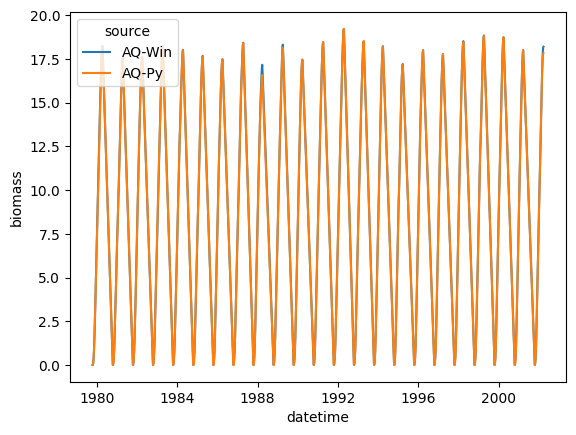

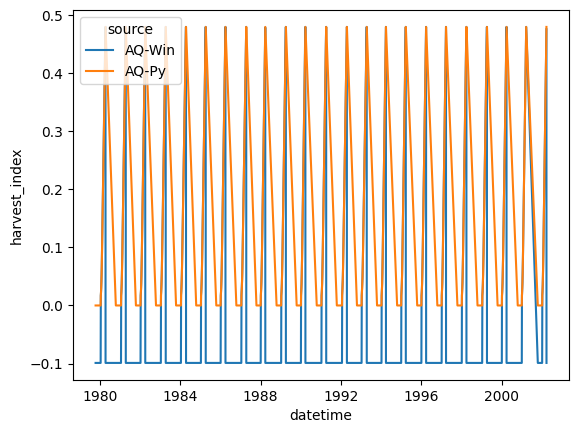

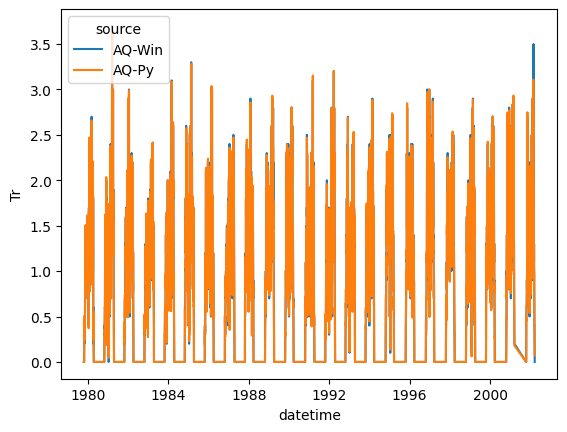

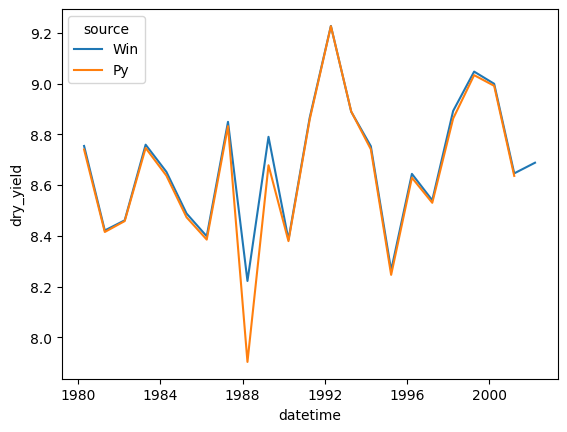

In [11]:
# Sandy loam soil
sandy_loam = Soil(soil_type='SandyLoam')

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/03/24',
                      weather_df=tunis_weather,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=wet_dry,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_SLSoil', model)

## Exercise 7.2 Local wheat variety

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_16968\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_16968\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


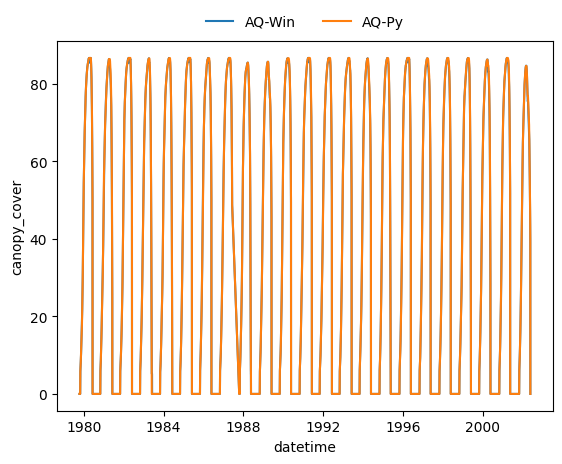

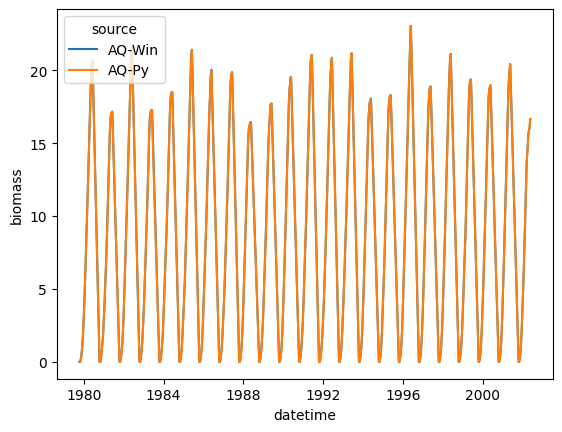

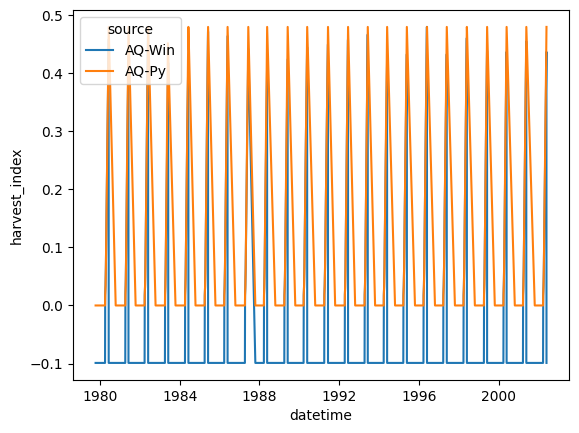

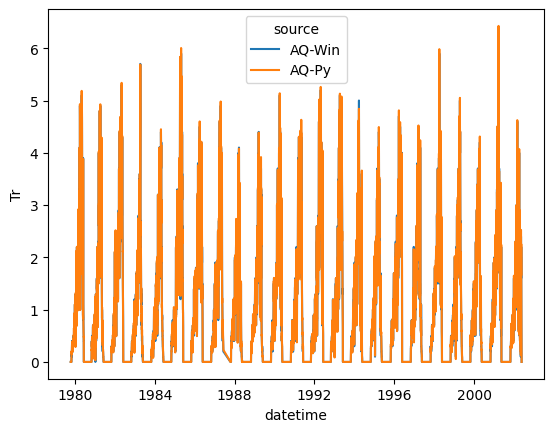

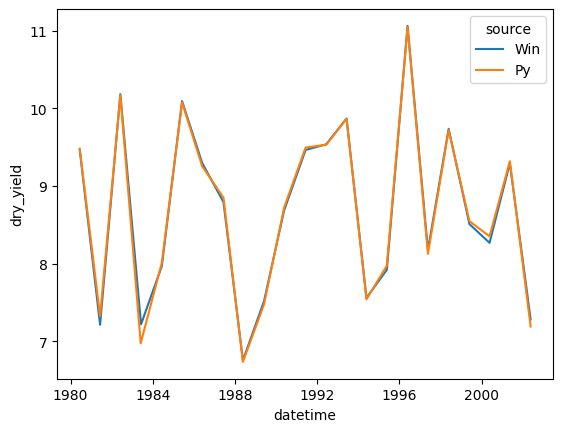

In [12]:
# Local wheat variety
local_wheat=Crop('WheatLongGDD', planting_date= '10/15')

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=tunis_weather,
                      soil=sandy_loam,
                      crop=local_wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=wet_dry,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_LongVar2', model)

## Exercise 7.3 Different initial conditions

WetDry

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_16968\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_16968\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


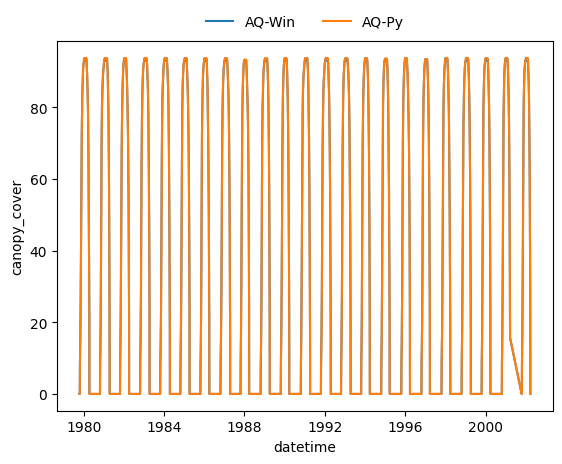

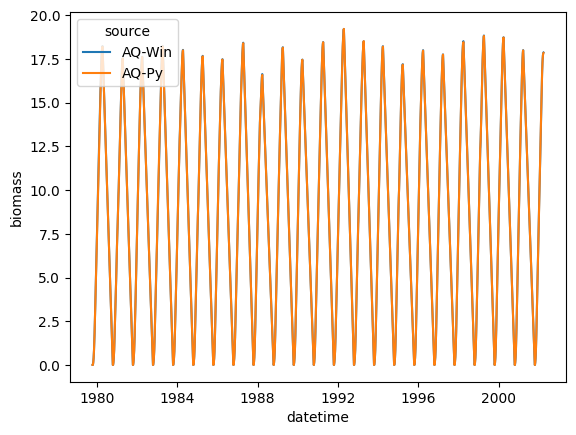

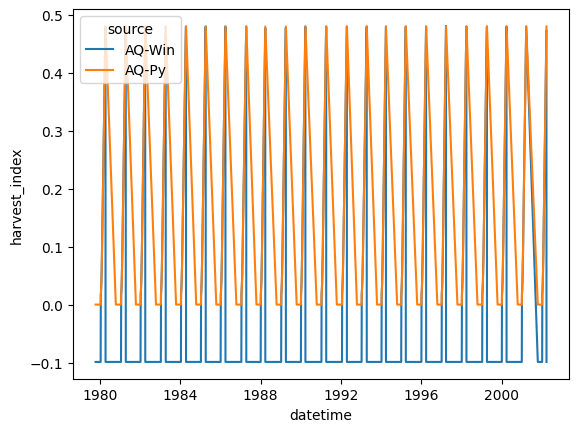

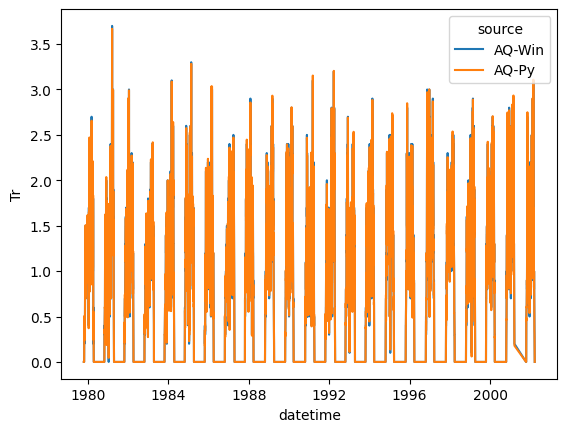

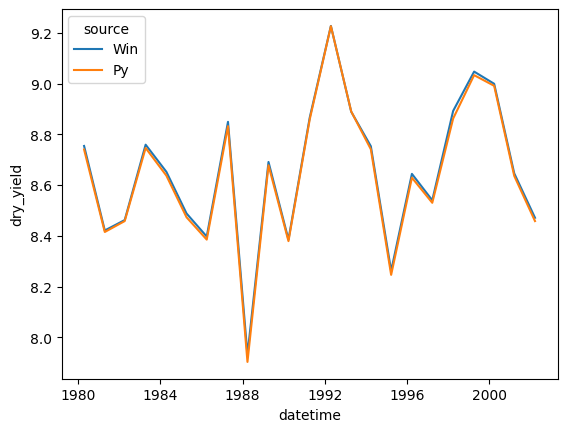

In [13]:
model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=tunis_weather,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=wet_dry,
                      )
model.run_model(till_termination=True)
run_comparison('Tun_WW_WetDry', model)

Field Capacity:

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


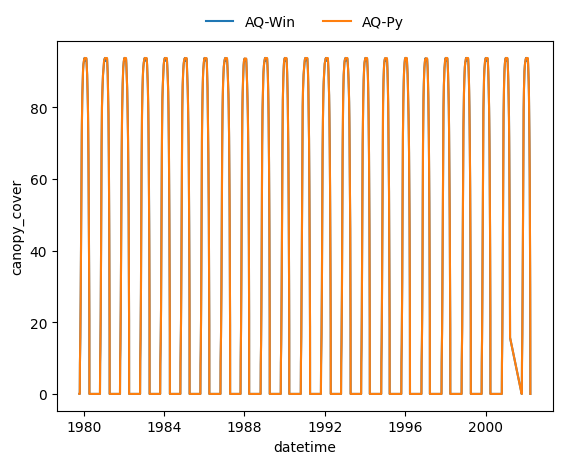

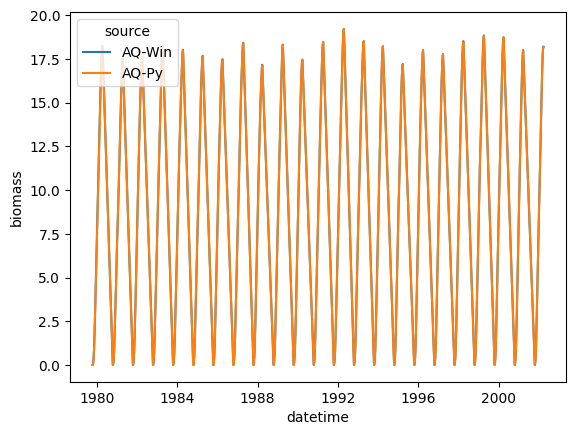

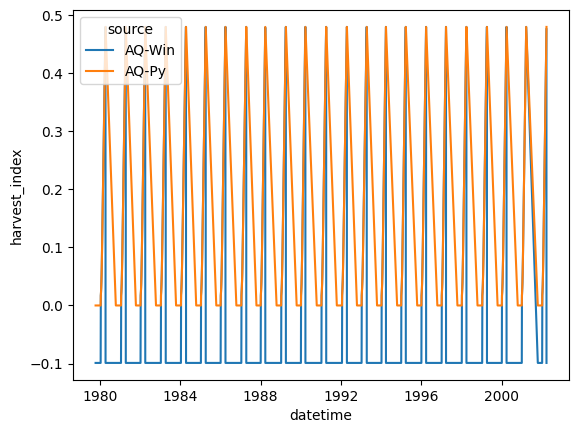

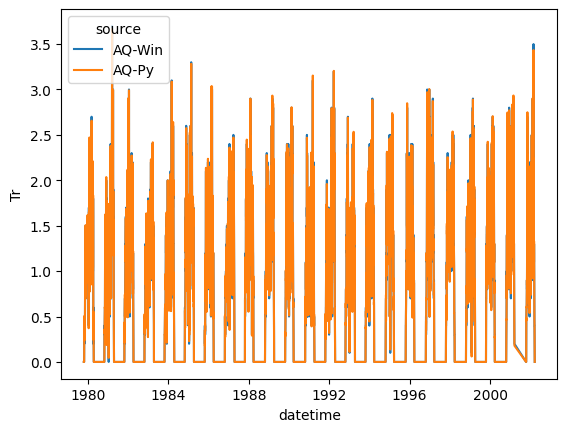

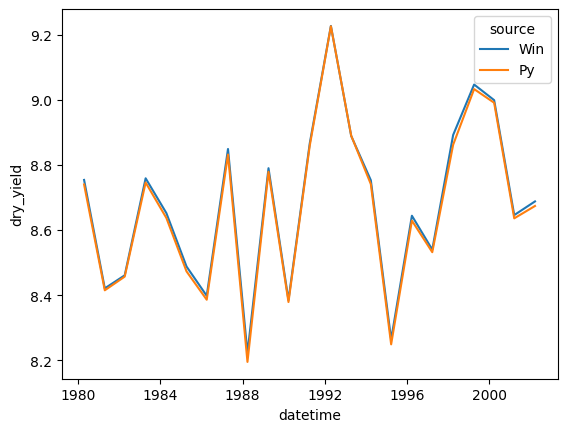

In [13]:
# Change initial water content 
field_capacity = InitialWaterContent(value=['FC'])

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=tunis_weather,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=field_capacity,
                      )
model.run_model(till_termination=True)
run_comparison('Tun_WW_FC', model)

30% TAW

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


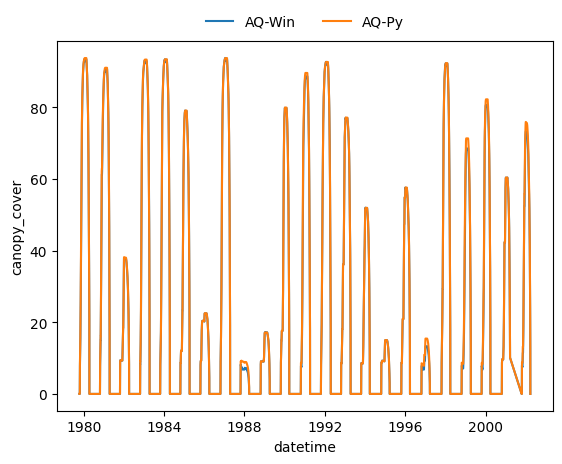

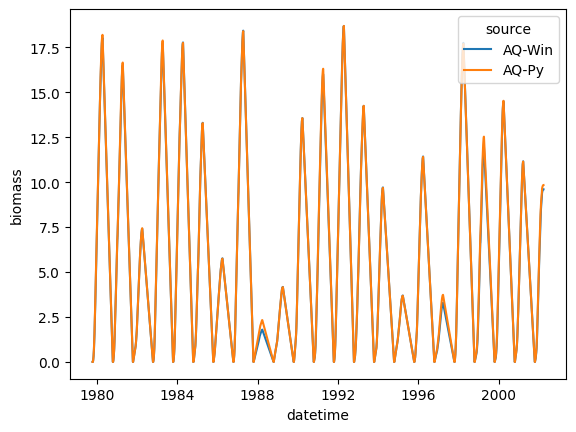

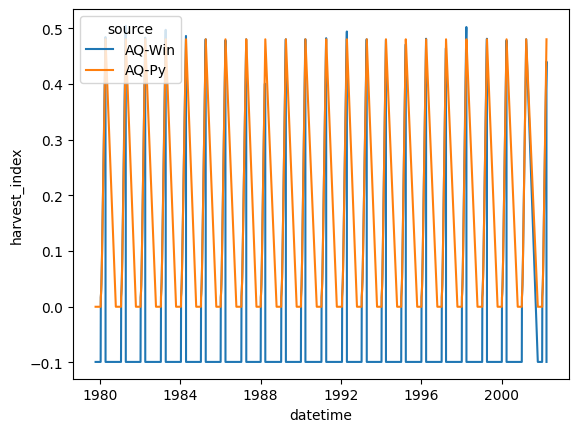

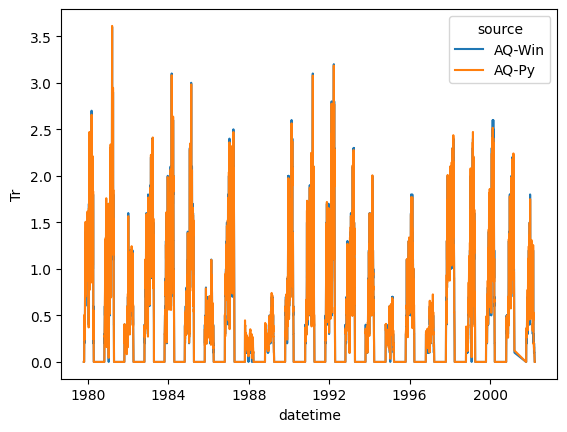

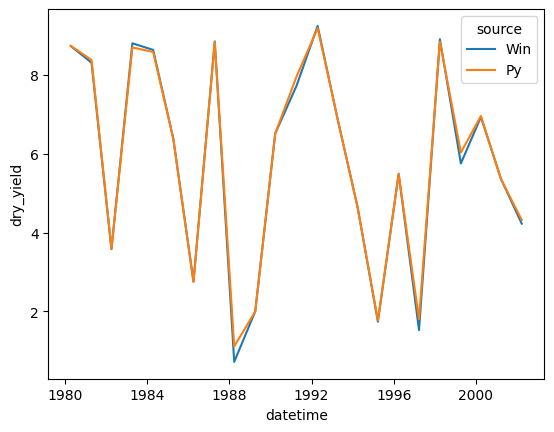

In [14]:
# Change initial water content
iwc30taw = InitialWaterContent('Pct','Layer',[1],[30])

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=tunis_weather,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=iwc30taw,
                      )
model.run_model(till_termination=True)
run_comparison('Tun_WW_30TAW', model)

75% TAW

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


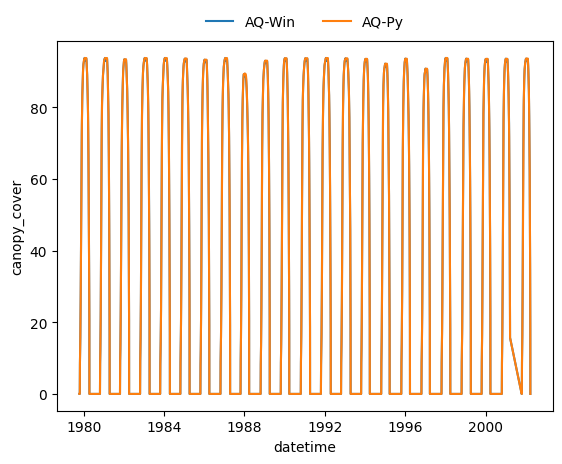

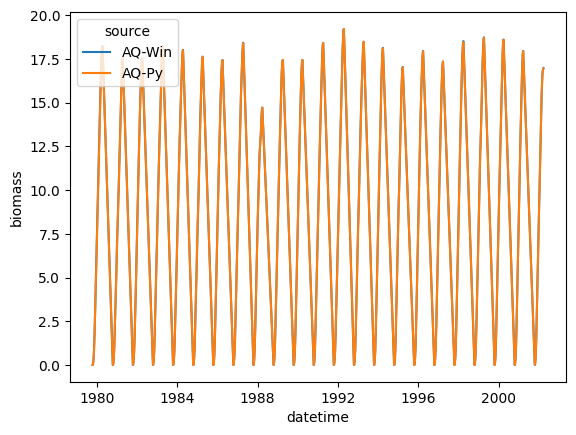

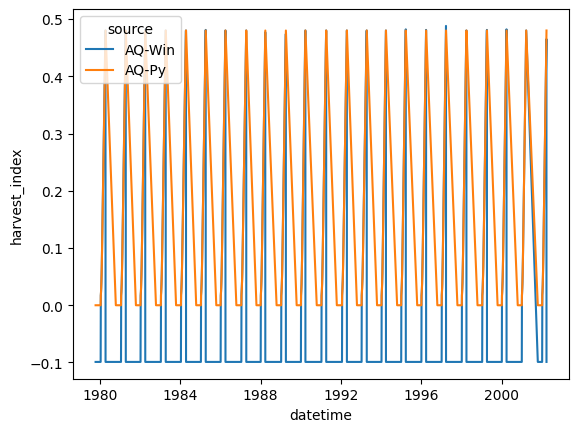

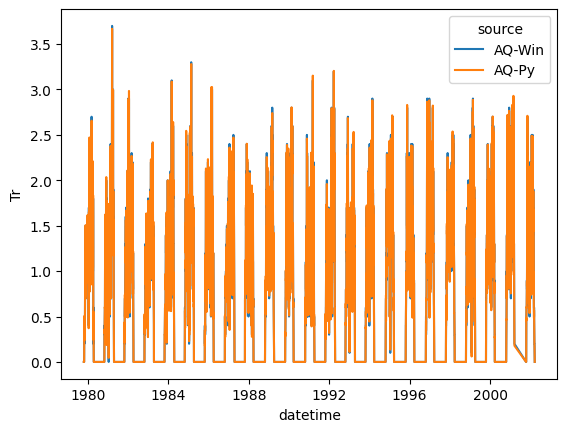

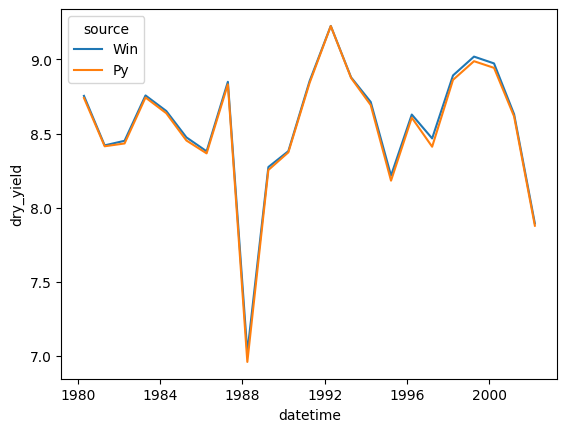

In [15]:
# Change initial water content
iwc75taw = InitialWaterContent('Pct','Layer',[1],[75])

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=tunis_weather,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=iwc75taw,
                      )
model.run_model(till_termination=True)
run_comparison('Tun_WW_75TAW', model)

## Exercise 7.6 Net irrigation requirement

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


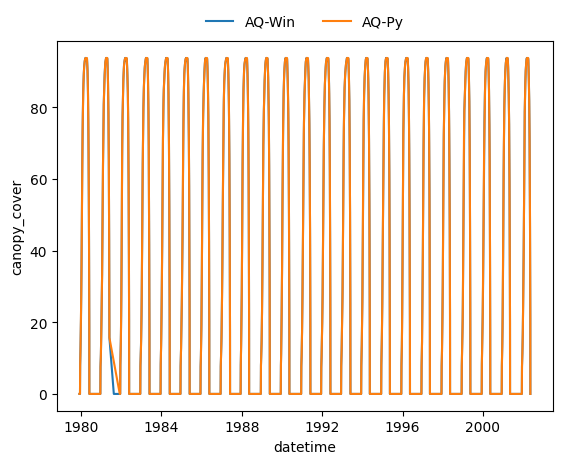

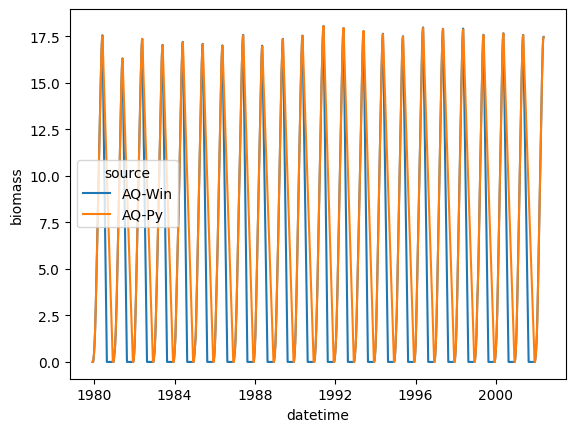

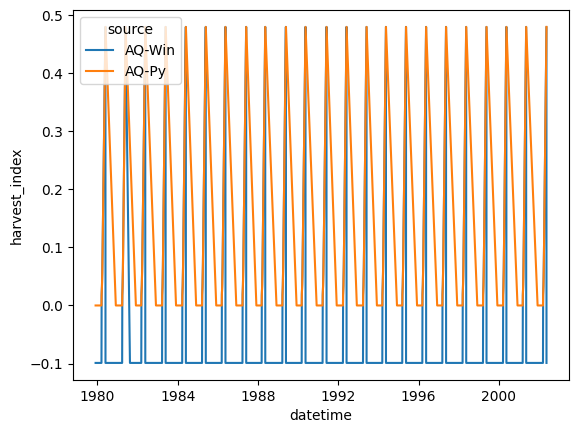

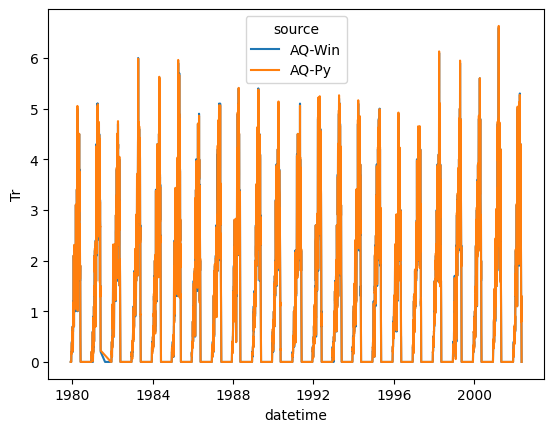

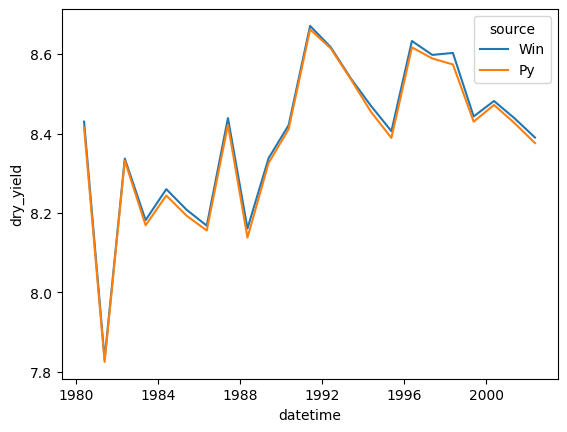

In [16]:
# Exercise states 30% of RAW, that's what I have input into the irrigation file in AQ-Win
# AQ-Py only deals with TAW, not RAW, so a conversion must be done.
# Conversion is based on the p_up2 attribute of crop, reflects proportion of TAW that is RAW.
# In this case (PotatoLocalGDD) has p_up2 of 0.6 so 35 * 0.6 = 21
net_irr = IrrigationManagement(irrigation_method=4,net_irr=78.26)
wp = InitialWaterContent(value=['WP'])
wheat_dec = Crop('WheatGDD',planting_date='12/01',harvest_date='07/30')

model = AquaCropModel(sim_start_time=f'{1979}/08/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=tunis_weather,
                      soil=sandy_loam,
                      crop=wheat_dec,
                      irrigation_management=net_irr,
                      initial_water_content=wp,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_NetIrr', model)

## Exercise 7.7 Assess deficit irrigation schedules

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


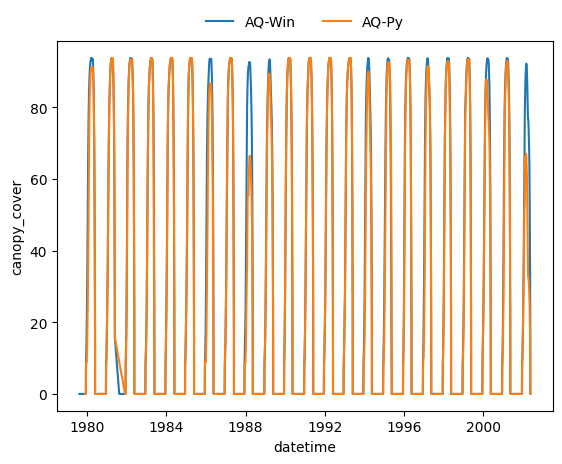

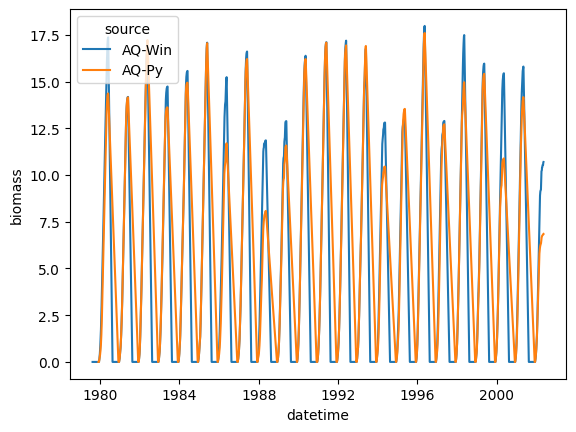

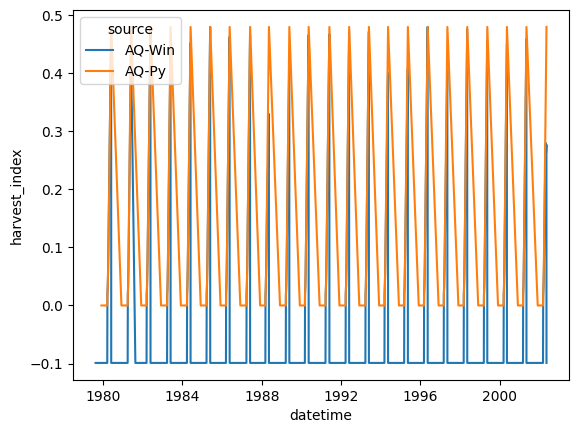

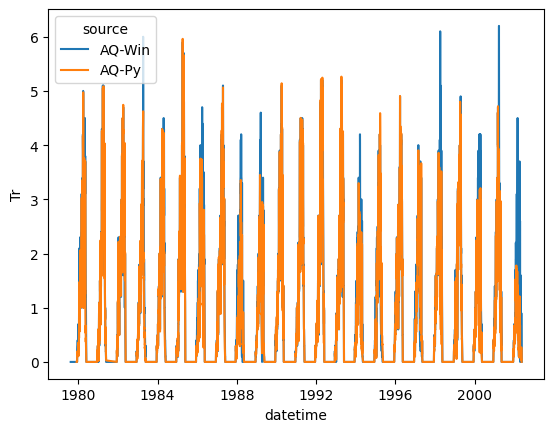

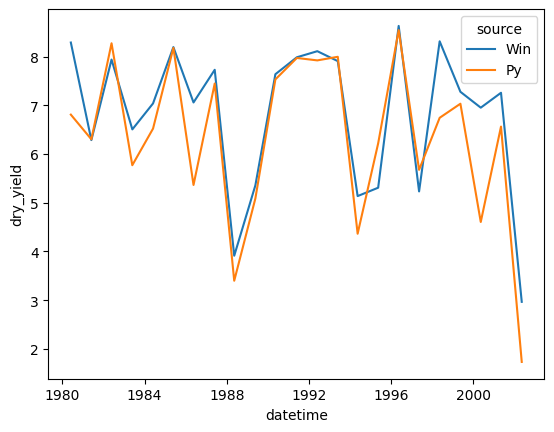

In [17]:
all_days=pd.date_range('1979/12/01', '2001/12/01',freq='12MS')

dates=[]

for each_start in all_days:
    app1=each_start
    app2=each_start+pd.Timedelta(30,'d')
    app3=each_start+pd.Timedelta(60,'d')
    dates.extend([app1,app2,app3])

n_years=len(all_days)
depths=[30,40,40]*n_years

schedule=pd.DataFrame([dates,depths]).T # create pandas DataFrame
schedule.columns=['Date','Depth'] # name columns

net_irr = IrrigationManagement(irrigation_method=3, Schedule=schedule)
wp = InitialWaterContent(wc_type='Pct',method='Layer',depth_layer=[1],value=[10])
wheat_dec = Crop('WheatGDD',planting_date='12/01')

model = AquaCropModel(sim_start_time=f'{1979}/08/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=tunis_weather,
                      soil=sandy_loam,
                      crop=wheat_dec,
                      irrigation_management=net_irr,
                      initial_water_content=wp,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_Deficit2', model)

# Exercise 8

## Exercise 8.2 Paddy rice in Hyderabad planting dates

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


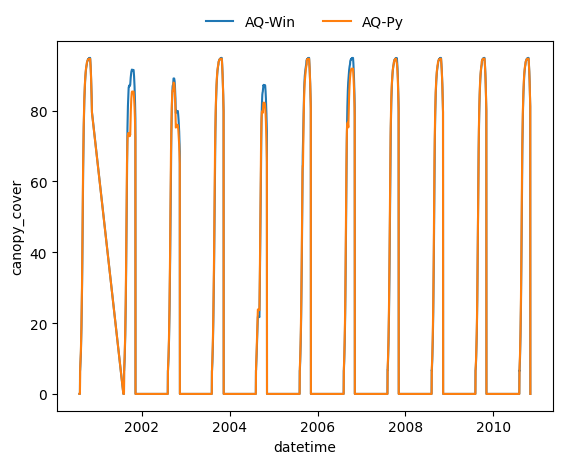

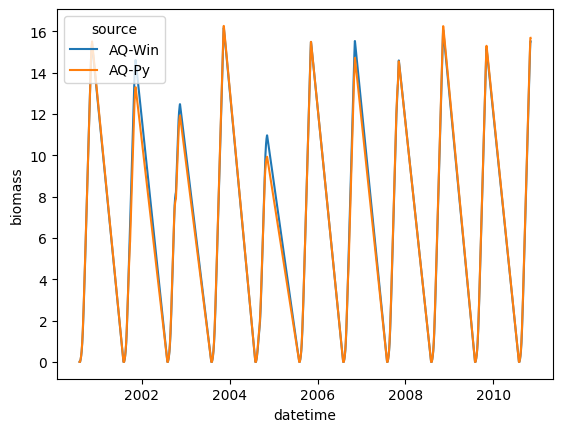

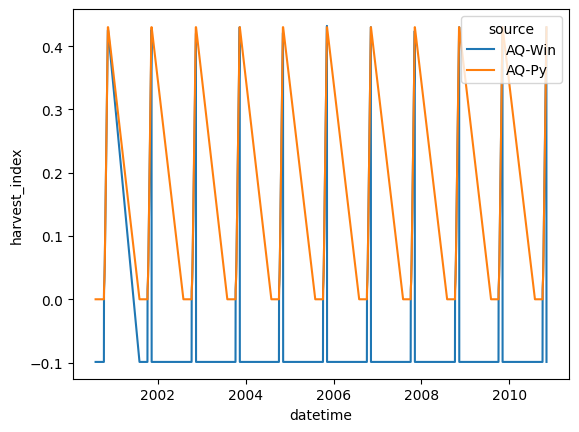

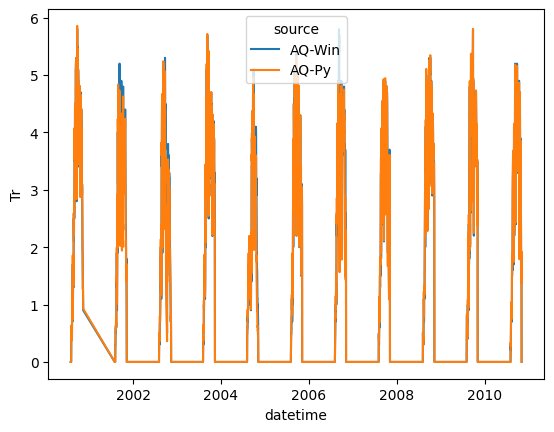

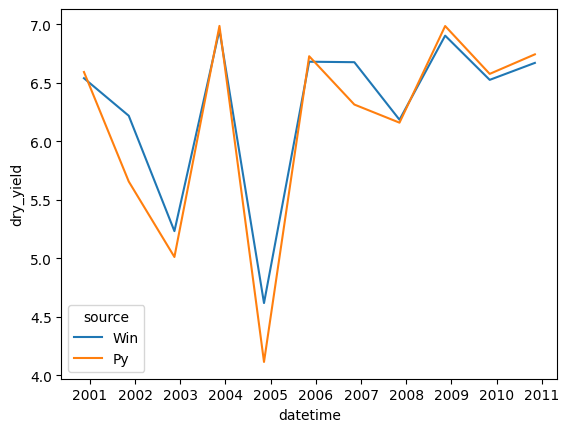

In [18]:
# Hyderabad climate
filepath=get_filepath('hyderabad_climate.txt')
hyderabad_weather = prepare_weather(filepath)

# Hyderabad soil
paddy_soil = Soil(soil_type='Paddy')

# crop
local_rice = Crop('localpaddy', planting_date='08/01')

# IWC
fc = InitialWaterContent(value=['FC'])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

# field management
bunds20 = FieldMngt(bunds=True, z_bund=0.20)

model = AquaCropModel(sim_start_time=f'{2000}/08/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      field_management=bunds20,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_1Aug_check', model)

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


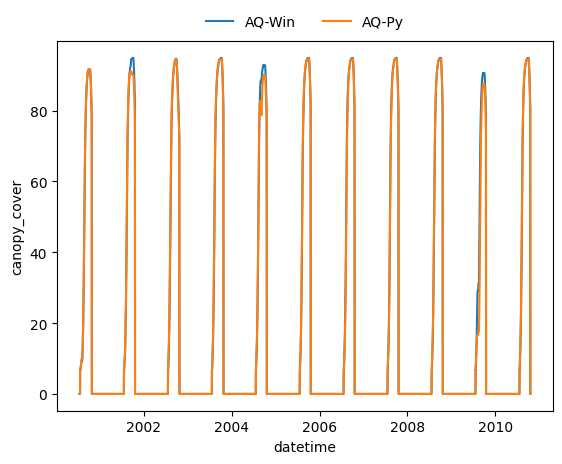

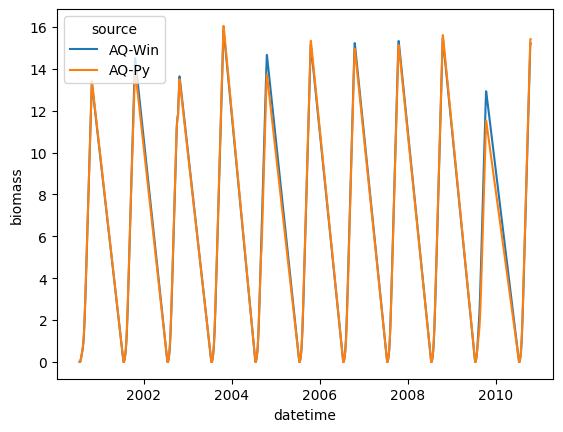

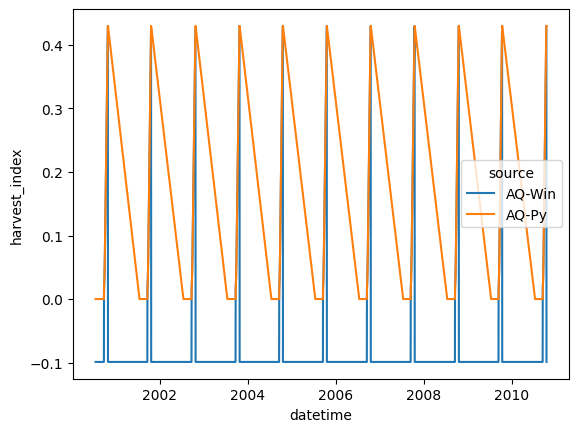

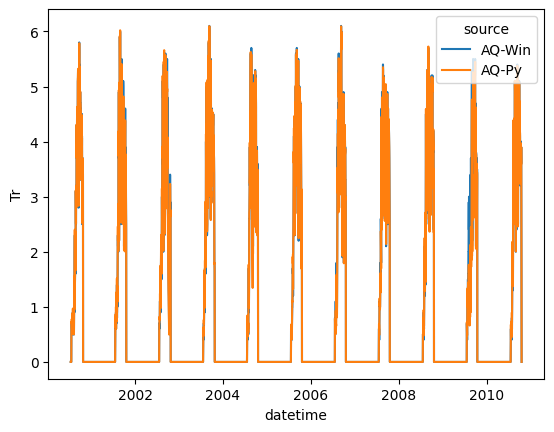

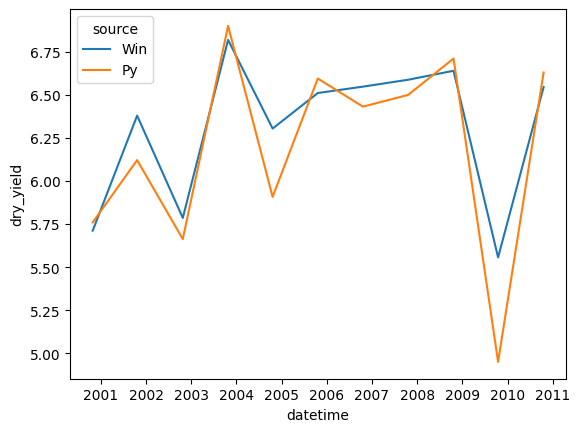

In [19]:
# crop
local_rice = Crop('localpaddy', planting_date='07/15')

model = AquaCropModel(sim_start_time=f'{2000}/07/15',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      field_management=bunds20,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_15Jul_check', model)

## Exercise 8.3 Initial conditions

Field capacity

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


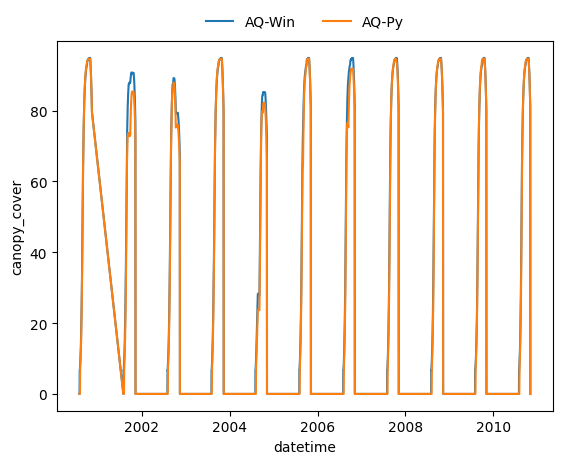

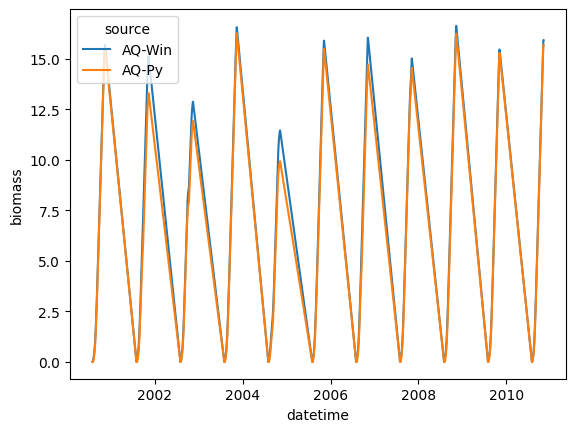

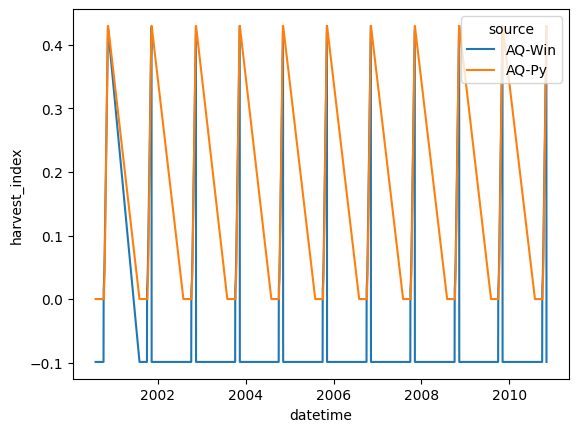

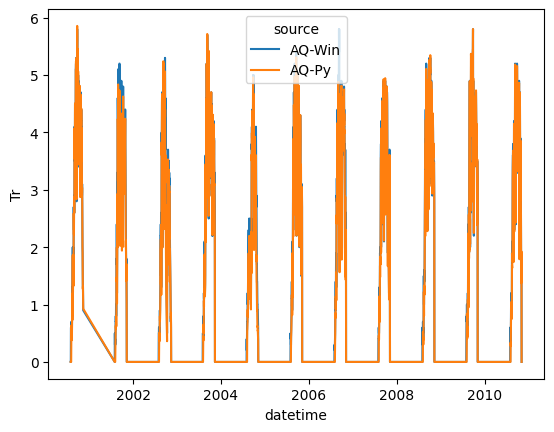

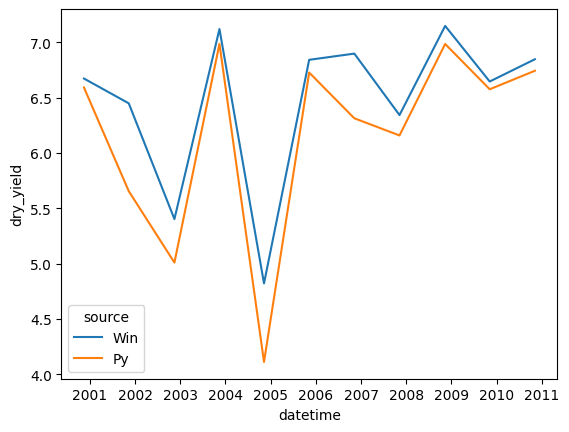

In [20]:
# Hyderabad climate
filepath=get_filepath('hyderabad_climate.txt')
hyderabad_weather = prepare_weather(filepath)

# Local Brussels soil
paddy_soil = Soil(soil_type='Paddy')

# crop
local_rice = Crop('localpaddy', planting_date='08/01')

# IWC
fc = InitialWaterContent(value=['FC'])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

model = AquaCropModel(sim_start_time=f'{2000}/01/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      irrigation_management=irr_mngt,
                      field_management=bunds20,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_FC', model)

30% TAW

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


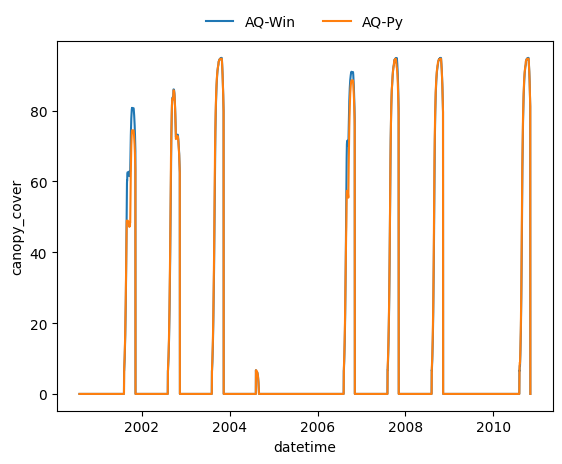

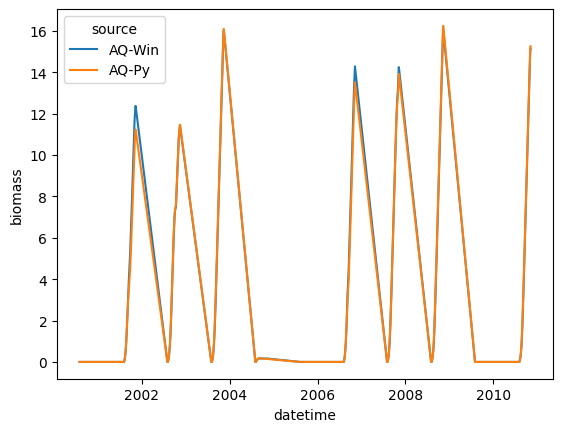

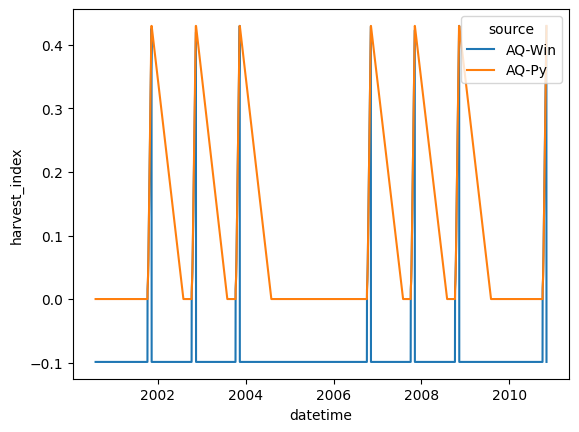

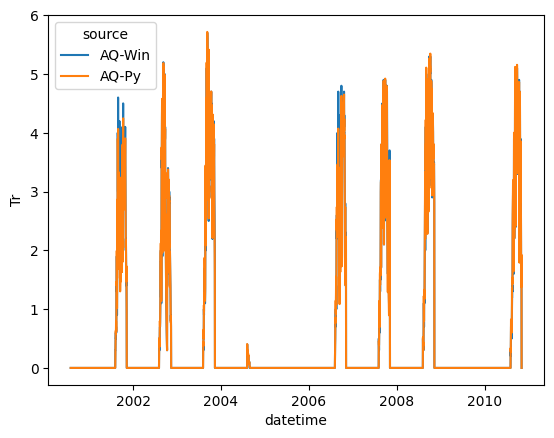

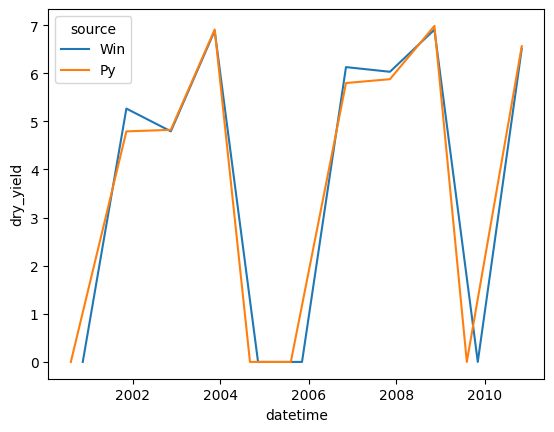

In [21]:
# IWC
taw30 = InitialWaterContent('Pct','Layer',[1],[30])
model = AquaCropModel(sim_start_time=f'{2000}/01/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      irrigation_management=irr_mngt,
                      field_management=bunds20,
                      initial_water_content=taw30,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_30TAW', model)

75% TAW

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


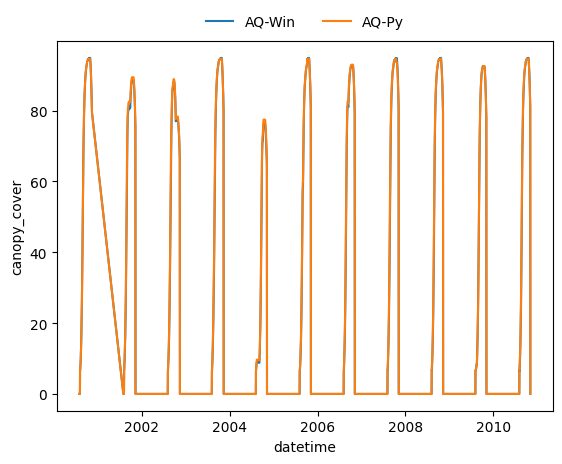

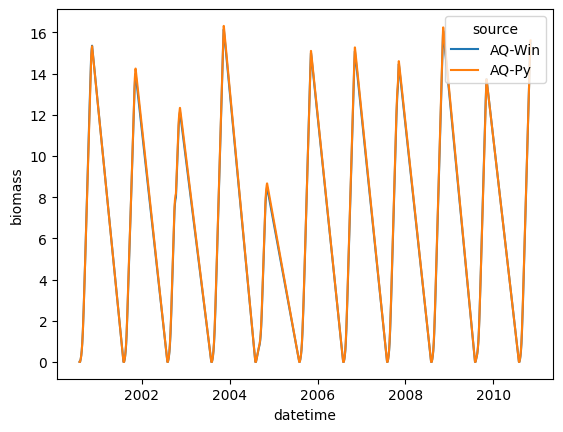

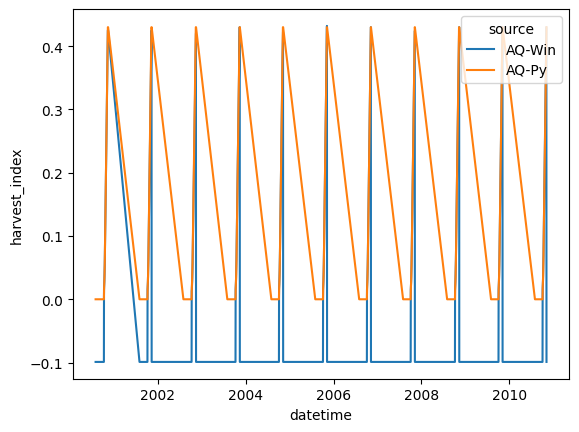

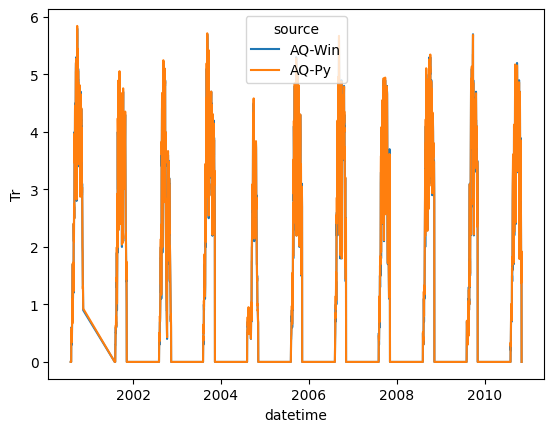

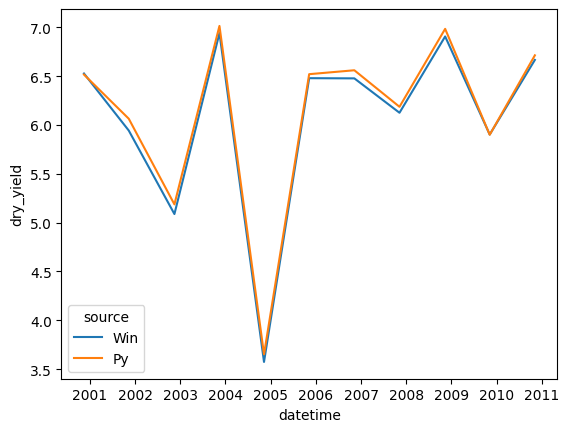

In [22]:
# IWC
taw75 = InitialWaterContent('Pct','Layer',[1,2],[75,75])

model = AquaCropModel(sim_start_time=f'{2000}/01/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      field_management=bunds20,
                      irrigation_management=irr_mngt,
                      initial_water_content=taw75,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_75TAW', model)

Wet Top

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


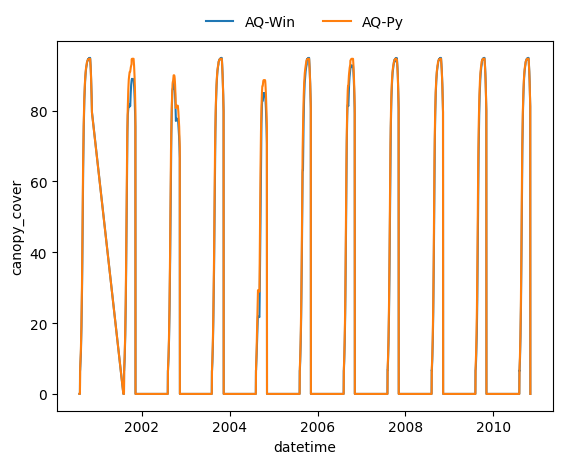

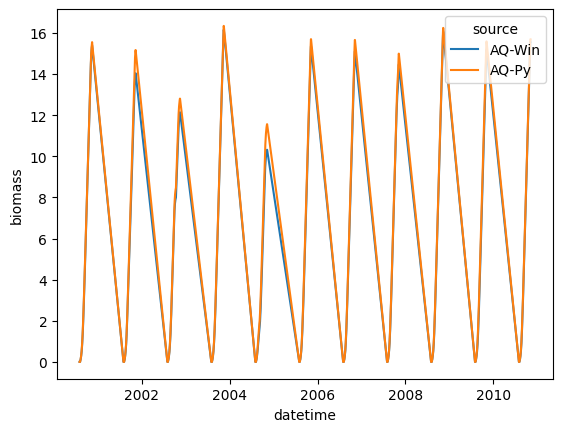

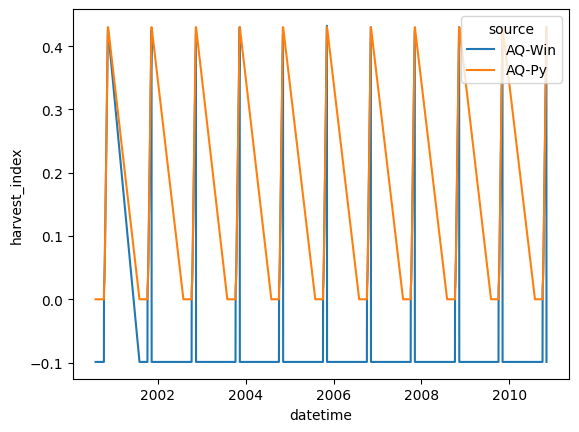

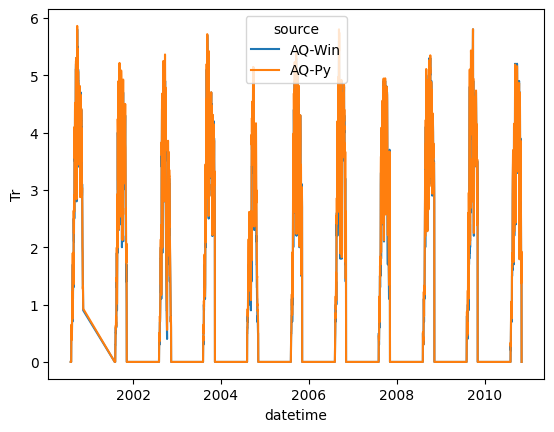

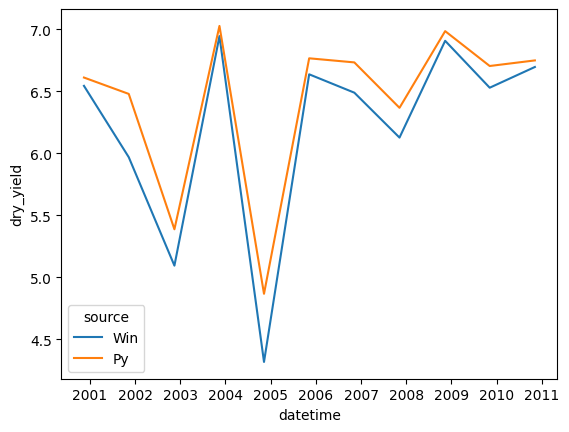

In [23]:
# IWC
wetTop = InitialWaterContent('Prop','Depth',[0.5,2],['FC','WP'])

model = AquaCropModel(sim_start_time=f'{2000}/01/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      field_management=bunds20,
                      irrigation_management=irr_mngt,
                      initial_water_content=wetTop,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_wetTop', model)

## Exercise 8.7 Irr. req. with shallow groundwater table

### a\) 1m groundwater

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_8920\1061039962.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_8920\1061039962.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_water = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'WABAL.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_8920\1061039962.py:132: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid t

Index(['day', 'month', 'year', 'DAP', 'Stage', 'GD', 'Z', 'StExp', 'StSto',
       'StSen', 'StSalt', 'StWeed', 'CC', 'CCw', 'StTr', 'Kc(Tr)', 'Trx', 'Tr',
       'TrW', 'Tr/Trx', 'WP', 'Biomass', 'HI', 'Y(dry)', 'Y(fresh)',
       'Brelative', 'WPet', 'Bin', 'Bout', 'datetime'],
      dtype='object')
Index(['day_x', 'month_x', 'year_x', 'DAP_x', 'Stage_x', 'GD', 'Z', 'StExp',
       'StSto', 'StSen', 'StSalt', 'StWeed', 'CC', 'CCw', 'StTr', 'Kc(Tr)',
       'Trx_x', 'Tr', 'TrW', 'Tr/Trx_x', 'WP', 'Biomass', 'HI', 'Y(dry)',
       'Y(fresh)', 'Brelative', 'WPet', 'Bin', 'Bout', 'datetime', 'day_y',
       'month_y', 'year_y', 'DAP_y', 'Stage_y', 'WCTot', 'Rain', 'Irri',
       'Surf', 'Infilt', 'RO', 'Drain', 'CR', 'Zgwt', 'Ex', 'E', 'E/Ex',
       'Trx_y', 'Tr/Trx_y', 'ETx', 'ET', 'ET/ETx'],
      dtype='object')
Index(['day_x', 'month_x', 'year_x', 'DAP_x', 'Stage_x', 'GD', 'Z', 'StExp',
       'StSto', 'StSen', 'StSalt', 'StWeed', 'CC', 'CCw', 'StTr', 'Kc(Tr)',
       'Trx_x', 'Tr',

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_8920\1061039962.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_a.rename(columns={'Wr' : 'Py_Wr'}, inplace=True)
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_8920\1061039962.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_b.rename(columns={'Wr' : 'Win_Wr'}, inplace=True)


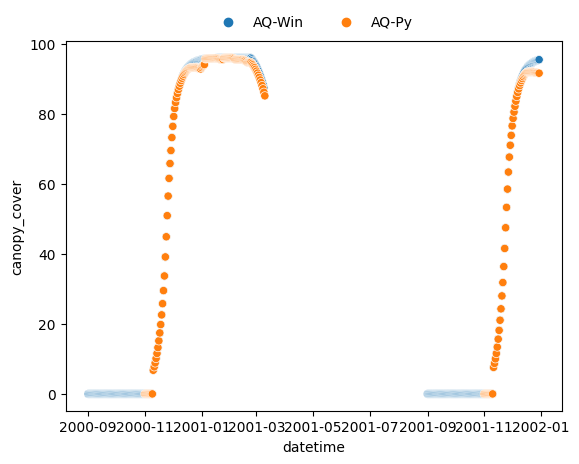

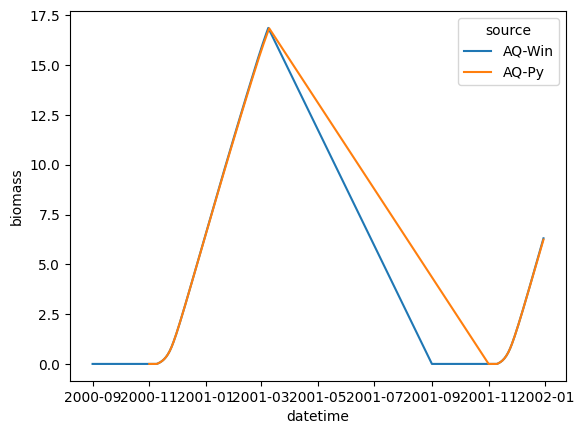

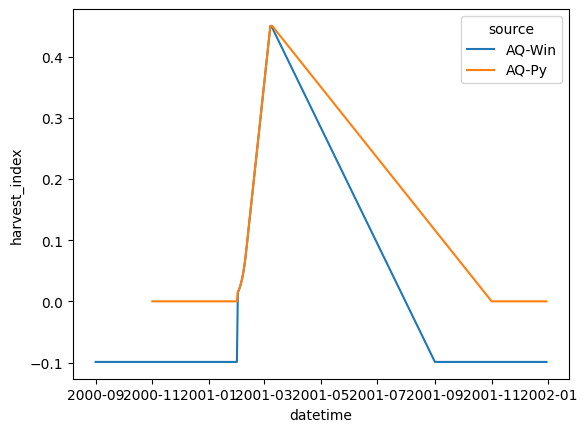

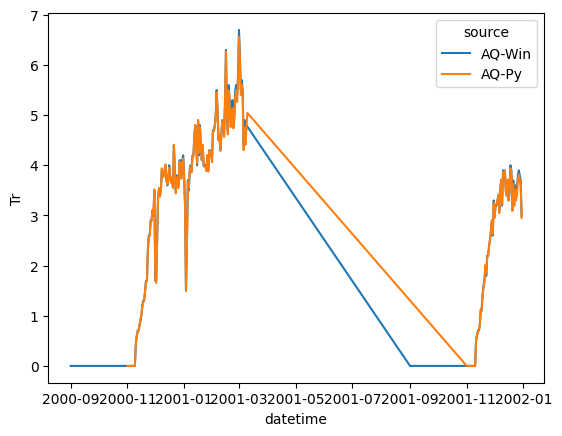

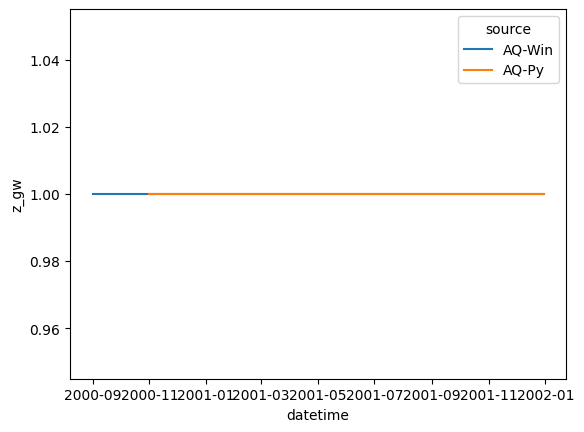

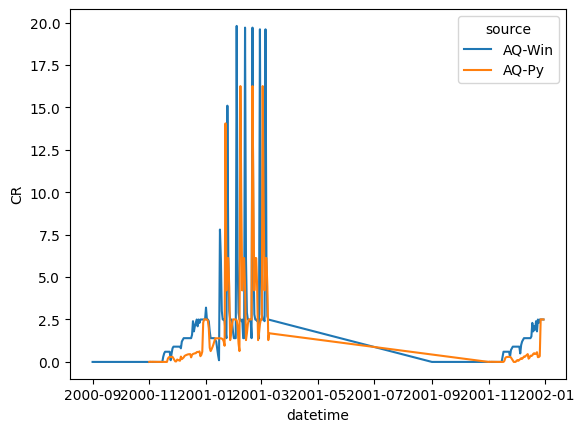

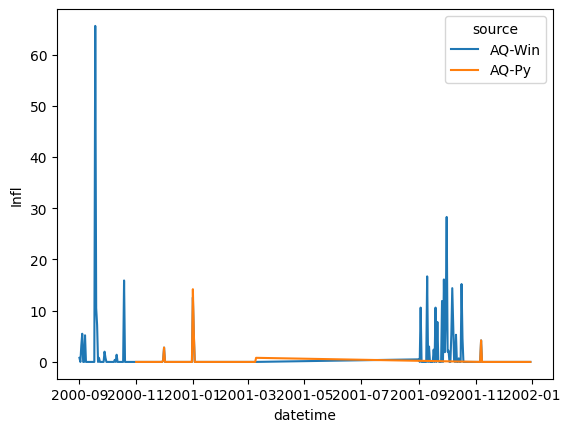

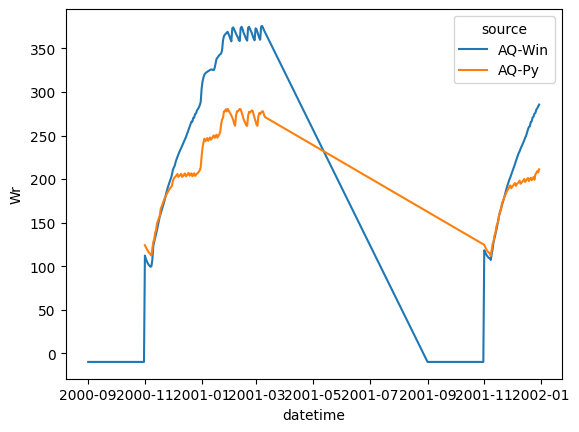

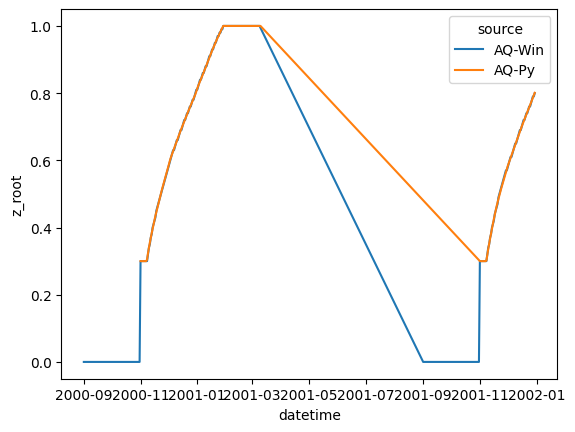

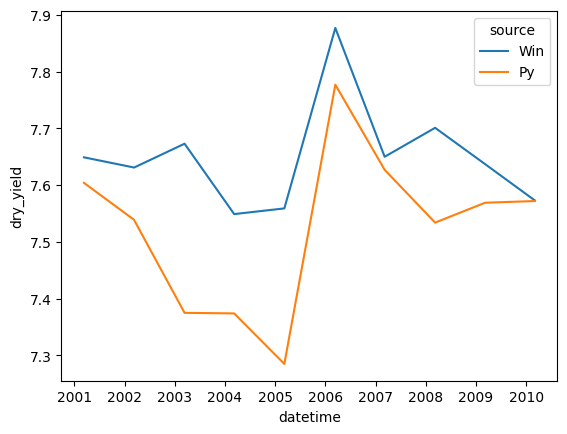

In [39]:
# Hyderabad climate
filepath=get_filepath('hyderabad_climate.txt')
hyderabad_weather = prepare_weather(filepath)

# Exercise states 35% of RAW, that's what I have input into the irrigation file in AQ-Win
# AQ-Py only deals with TAW, not RAW, so a conversion must be done.
# Conversion is based on the p_up2 attribute of crop, reflects proportion of TAW that is RAW.
# In this case (WheatGDD) has p_up2 of 0.65 so 30 * 0.65 = 19.5
net_irr = IrrigationManagement(irrigation_method=4,NetIrrSMT=19.5)
clay_loam = Soil(soil_type='ClayLoam')
wheat_nov = Crop('WheatGDD', planting_date='11/01')
fc = InitialWaterContent(value=['FC'])
groundwater_1m = GroundWater('Y','Constant',dates=[f'{2000}/09/01'], values=[1])

model = AquaCropModel(sim_start_time=f'{2000}/09/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=clay_loam,
                      crop=wheat_nov,
                      irrigation_management=net_irr,
                      initial_water_content=fc,
                      groundwater=groundwater_1m,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_W_NetIrr_GW1m_2', model)

### b\) 2m groundwater

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_11660\3228501789.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_11660\3228501789.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_water = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'WABAL.OUT',


Index(['day', 'month', 'year', 'DAP', 'Stage', 'GD', 'Z', 'StExp', 'StSto',
       'StSen', 'StSalt', 'StWeed', 'CC', 'CCw', 'StTr', 'Kc(Tr)', 'Trx', 'Tr',
       'TrW', 'Tr/Trx', 'WP', 'Biomass', 'HI', 'Y(dry)', 'Y(fresh)',
       'Brelative', 'WPet', 'Bin', 'Bout', 'datetime'],
      dtype='object')
Index(['day_x', 'month_x', 'year_x', 'DAP_x', 'Stage_x', 'GD', 'Z', 'StExp',
       'StSto', 'StSen', 'StSalt', 'StWeed', 'CC', 'CCw', 'StTr', 'Kc(Tr)',
       'Trx_x', 'Tr', 'TrW', 'Tr/Trx_x', 'WP', 'Biomass', 'HI', 'Y(dry)',
       'Y(fresh)', 'Brelative', 'WPet', 'Bin', 'Bout', 'datetime', 'day_y',
       'month_y', 'year_y', 'DAP_y', 'Stage_y', 'WCTot', 'Rain', 'Irri',
       'Surf', 'Infilt', 'RO', 'Drain', 'CR', 'Zgwt', 'Ex', 'E', 'E/Ex',
       'Trx_y', 'Tr/Trx_y', 'ETx', 'ET', 'ET/ETx'],
      dtype='object')
Index(['day_x', 'month_x', 'year_x', 'DAP_x', 'Stage_x', 'GD', 'Z', 'StExp',
       'StSto', 'StSen', 'StSalt', 'StWeed', 'CC', 'CCw', 'StTr', 'Kc(Tr)',
       'Trx_x', 'Tr',

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_11660\3228501789.py:132: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


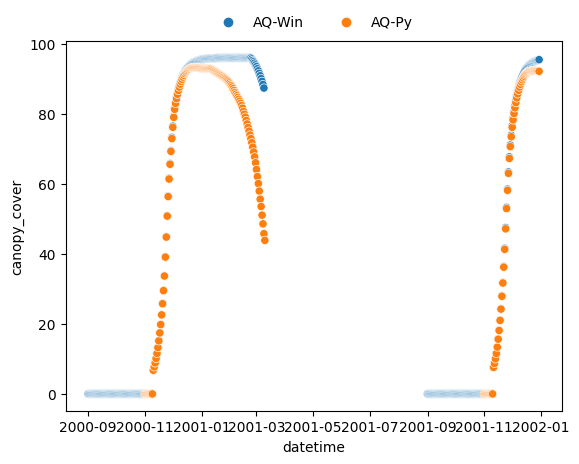

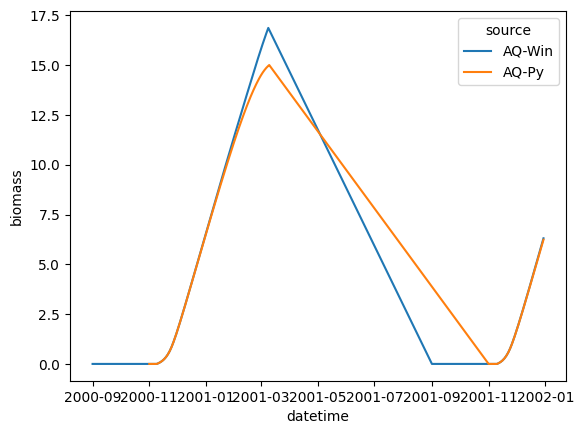

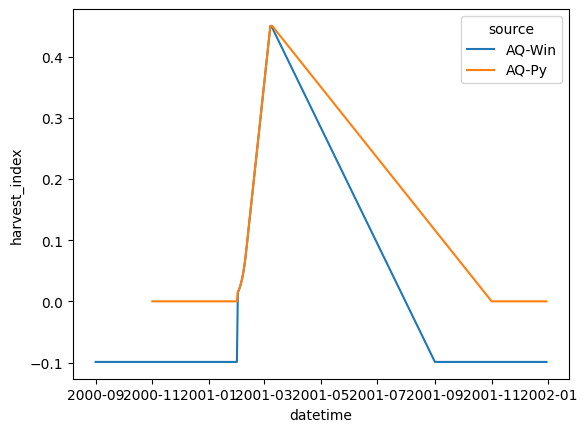

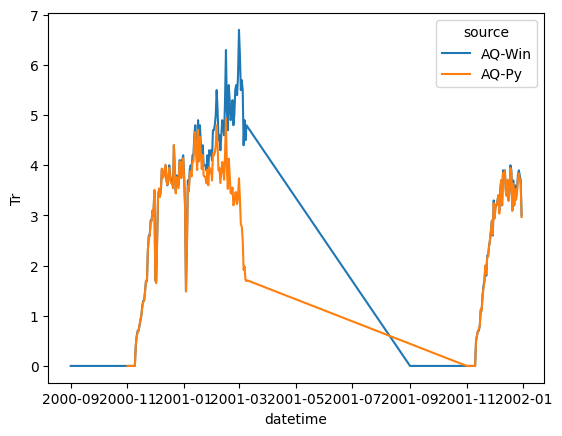

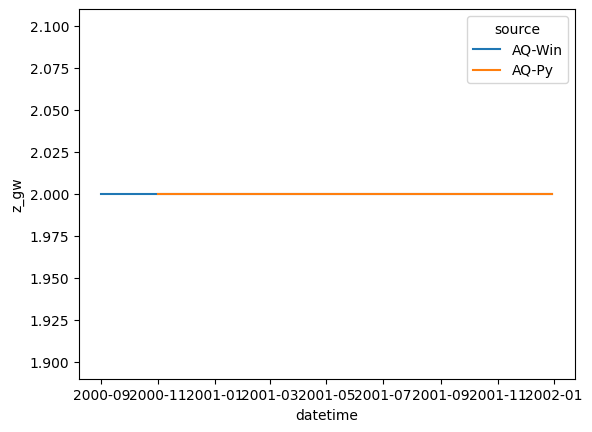

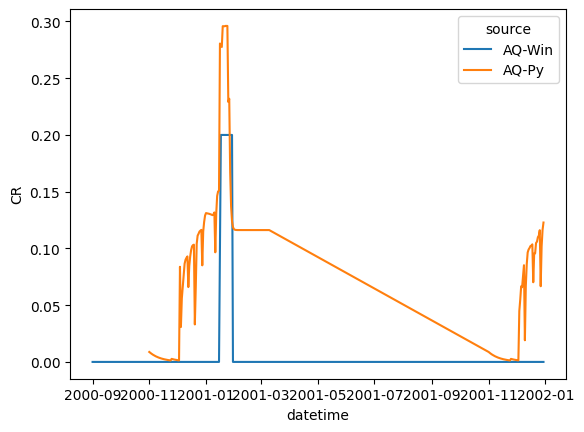

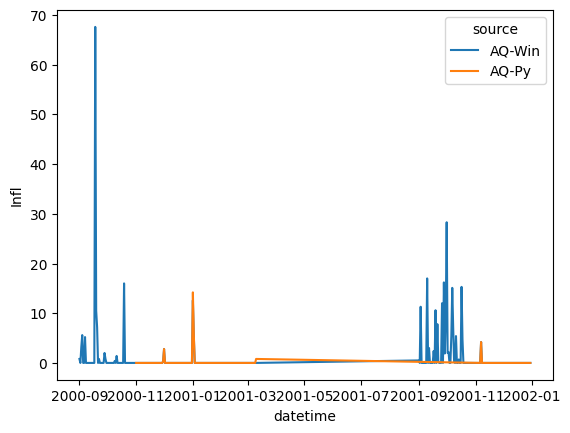

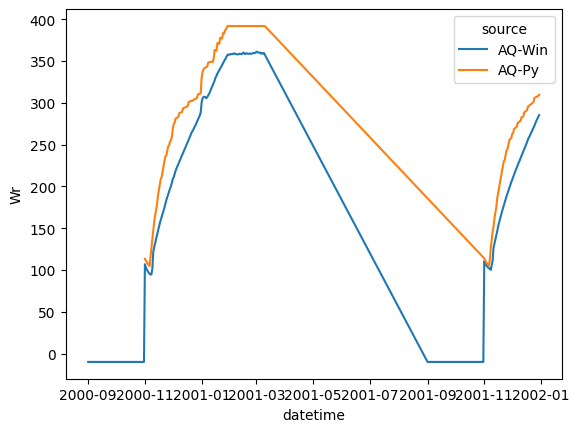

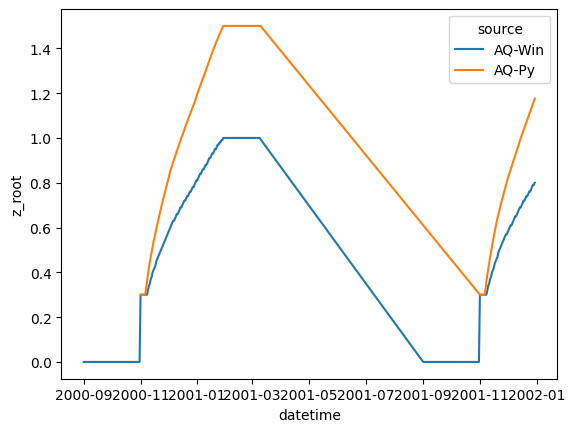

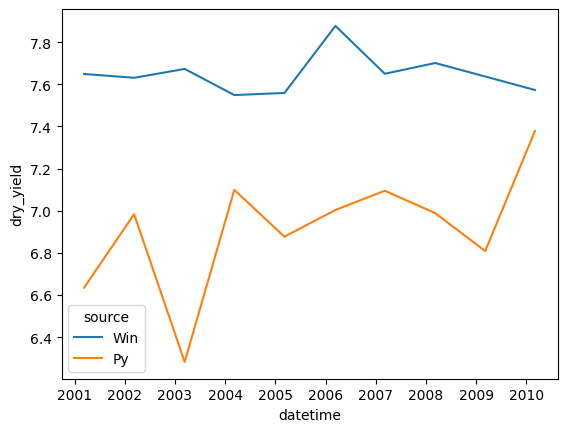

In [9]:
groundwater_2m = GroundWater('Y','Constant',dates=[f'{2000}/09/01'], values=[2])

model = AquaCropModel(sim_start_time=f'{2000}/09/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=clay_loam,
                      crop=wheat_nov,
                      irrigation_management=net_irr,
                      initial_water_content=fc,
                      groundwater=groundwater_2m,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_W_NetIrr_GW2m_2', model)

# Exercise 9

## Exercise 9.1 Potato in Brussels

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


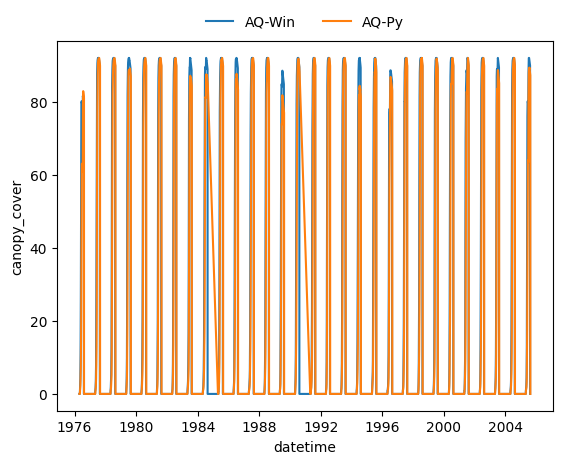

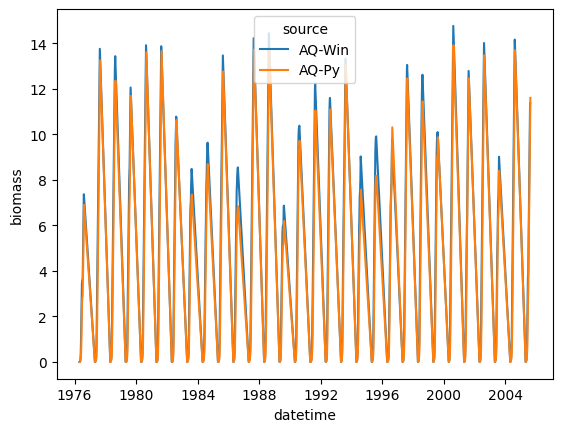

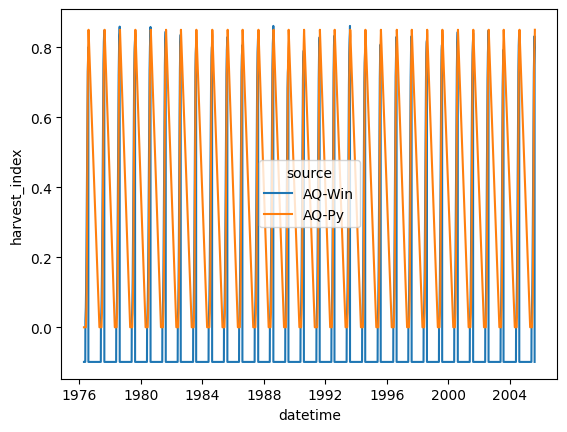

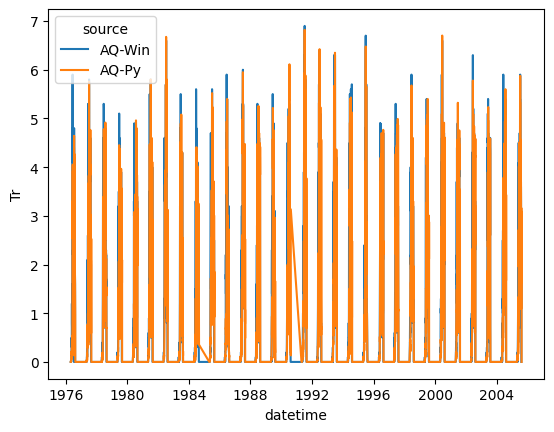

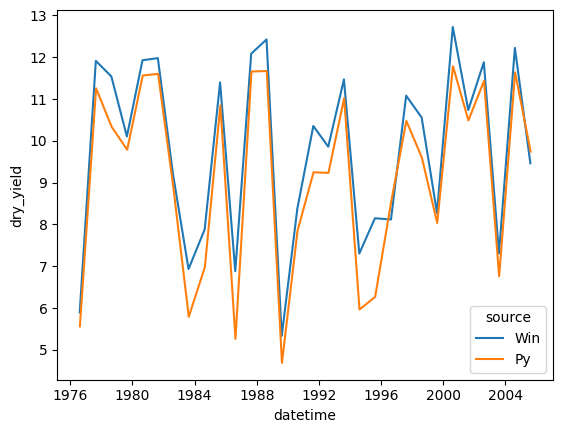

In [24]:
# Brussels climate
filepath=get_filepath('brussels_climate.txt')
brussels_weather = prepare_weather(filepath)

# Local Brussels soil
loam_soil = Soil(soil_type='Loam')

# crops
potato = Crop('PotatoLocalGDD', planting_date='04/25')

# IWC
fc = InitialWaterContent(value=['FC'])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

model = AquaCropModel(sim_start_time=f'{1976}/04/25', # 1976
                      sim_end_time=f'{2005}/12/31', # 2005
                      weather_df=brussels_weather,
                      soil=loam_soil,
                      crop=potato,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Bru_Pot', model)

#daily_outputs = run_comparison_v7('Bru_Pot', model)

Get soil profile data from windows outputs

In [25]:
win_daily_outputs = extract_win_data('Bru_Pot2')

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\896082959.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=33)
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\896082959.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=27)
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_10504\896082959.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=19, index_col=False)
C:

In [26]:
#py_data=extract_py_data(py_model=model)

#print(py_data.columns)

In [27]:
# py_growth=daily_outputs[0]
# py_wflux=daily_outputs[1]
# py_wstorage=daily_outputs[2]
# #win_outputs=daily_outputs[0]

# print(py_growth.columns)
# print(py_wflux.columns)
# print(py_wstorage.columns)

win_outputs_88=win_daily_outputs[(win_daily_outputs['datetime'] > '1988-04-25') & (win_daily_outputs['datetime'] < '1988-12-31')]
py_outputs_88=py_data[(py_data['datetime'] > '1988-04-25') & (py_data['datetime'] < '1988-12-31')]
# start_year,start_month,start_day='1987','04','25'
# py_wflux['datetime']=py_wflux.apply(lambda x:datetime.datetime(int(x['season_counter']+int(start_year)),int(start_month),int(start_day)+1)+datetime.timedelta(int(x['dap']-1)),axis=1)
# py_wflux['source']='AQ-Py'




combined_87_88=pd.concat([win_outputs_88, py_outputs_88])

g1=sns.lineplot(data=combined_87_88, x='datetime',y='Wr', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()

g1=sns.lineplot(data=combined_87_88, x='datetime',y='Tr', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()

g1=sns.lineplot(data=combined_87_88, x='datetime',y='canopy_cover', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()

g1=sns.lineplot(data=combined_87_88, x='datetime',y='z_root', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()

g1=sns.lineplot(data=combined_87_88, x='datetime',y='biomass', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()

g1=sns.lineplot(data=combined_87_88, x='datetime',y='harvest_index', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()

g1=sns.lineplot(data=combined_87_88, x='datetime',y='dry_yield', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()


NameError: name 'py_data' is not defined

In [ ]:
#combined_87_88.to_csv('combined-outputs.csv', index = False, encoding='utf-8')

: 

In [ ]:
#run_comparison('Bru_Pot2',model)

KeyError: 'season_counter'

## 9.4 Net irrigation requirement

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_11708\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_11708\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


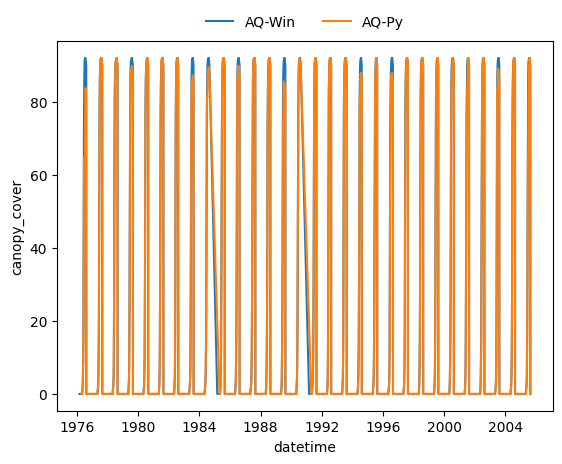

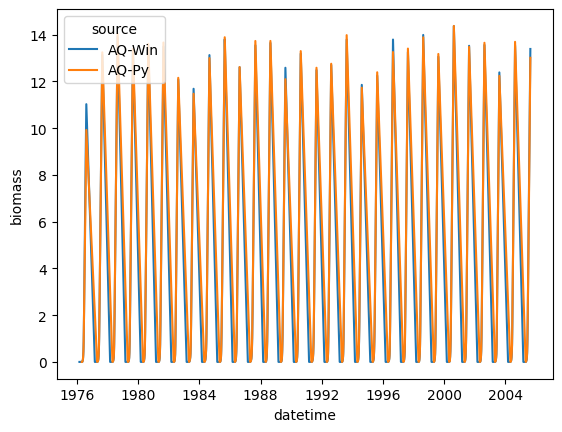

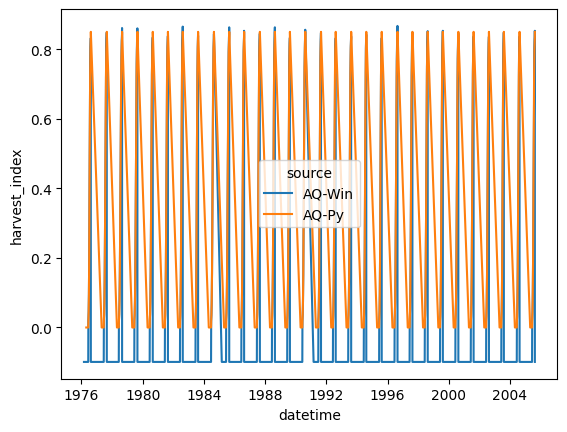

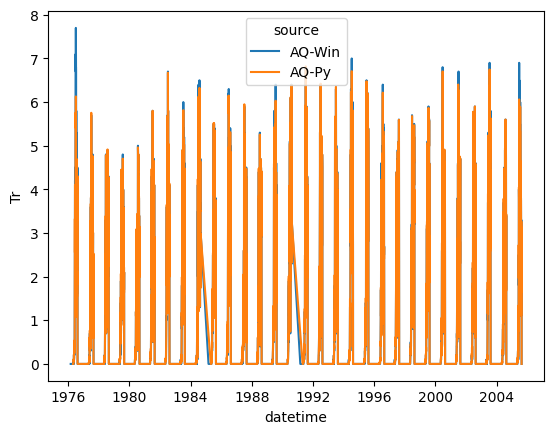

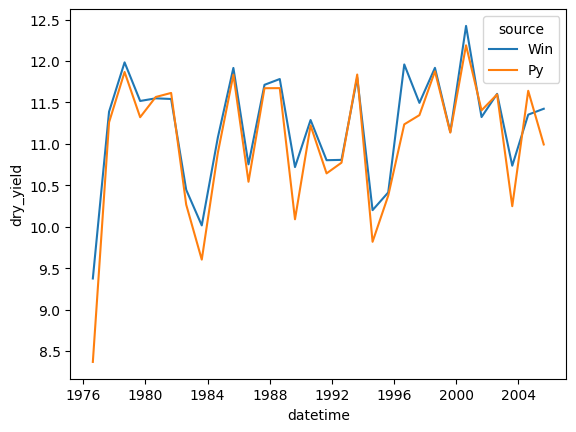

In [ ]:
# Exercise states 35% of RAW, that's what I have input into the irrigation file in AQ-Win
# AQ-Py only deals with TAW, not RAW, so a conversion must be done.
# Conversion is based on the p_up2 attribute of crop, reflects proportion of TAW that is RAW.
# In this case (PotatoLocalGDD) has p_up2 of 0.6 so 35 * 0.6 = 21

net_irr = IrrigationManagement(irrigation_method=4,NetIrrSMT=21)

model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loam_soil,
                      crop=potato,
                      irrigation_management=net_irr,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Bru_Pot_NetIrr2', model)

## 9.5 Generating irrigation schedules

In [ ]:
# function to return the irrigation depth to apply on next day
def get_depth(model, taw):    
    t = model._clock_struct.time_step_counter # current timestep
    if t>0 and model._init_cond.depletion/model._init_cond.taw > taw:
        depth=15
    else:
        depth=0

    return depth

36% RAW allowable depletion

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_11708\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_11708\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


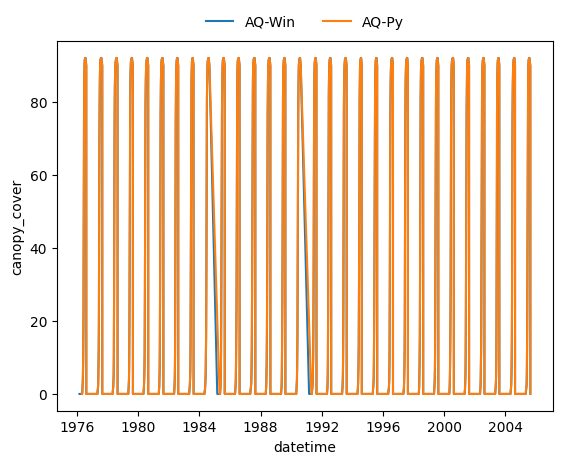

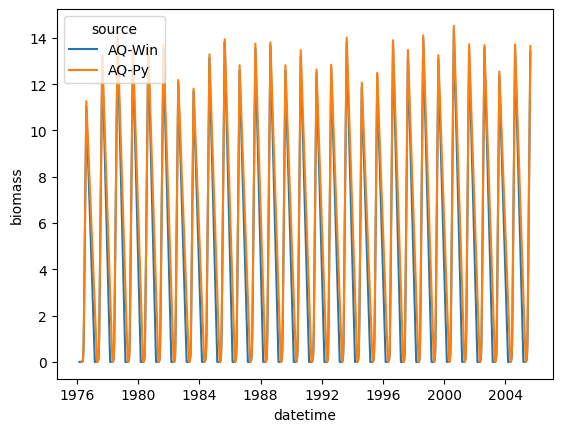

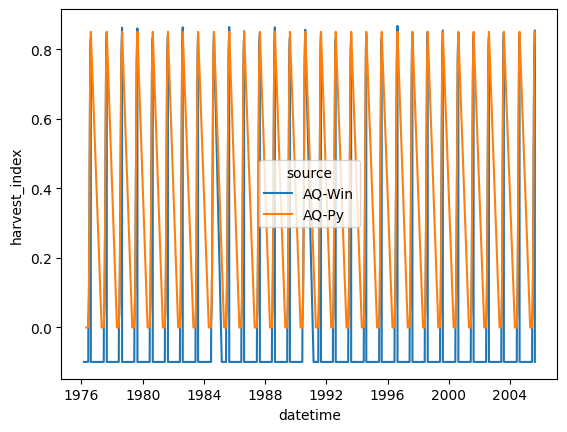

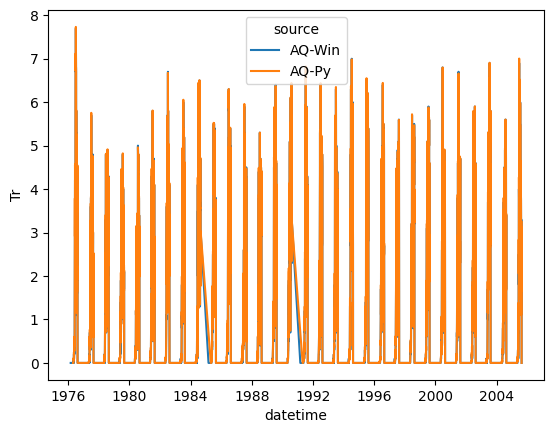

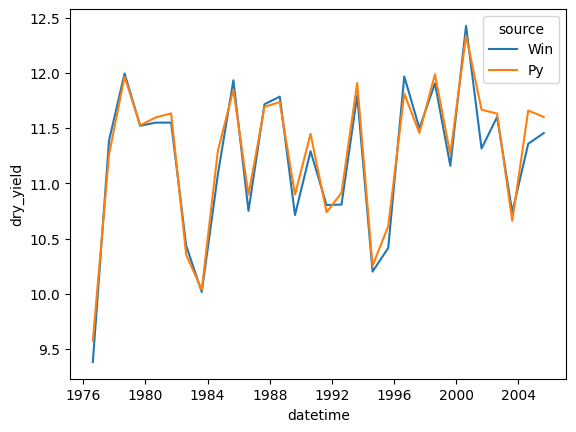

In [ ]:
# Loamy sand soil
loamy_sand = Soil(soil_type='LoamySand')

# crop
potato = Crop('PotatoLocalGDD', planting_date='04/25')

# create model with IrrMethod= Constant depth
model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loamy_sand,
                      crop=potato,
                      irrigation_management=IrrigationManagement(irrigation_method=5,),
                      initial_water_content=fc,
                      )
                       

model._initialize()

while model._clock_struct.model_is_finished is False:    
    # get depth to apply, RAW = 36, p_up2 = 0.6 so TAW = 21.6
    depth=get_depth(model,0.216)
    
    model._param_struct.IrrMngt.depth=depth

    model.run_model(initialize_model=False)

run_comparison('Bru_Pot_Irr36RAW2', model)

100% RAW

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_11708\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_11708\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


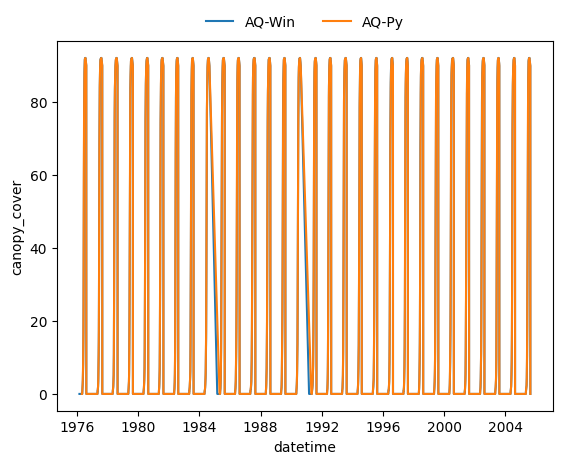

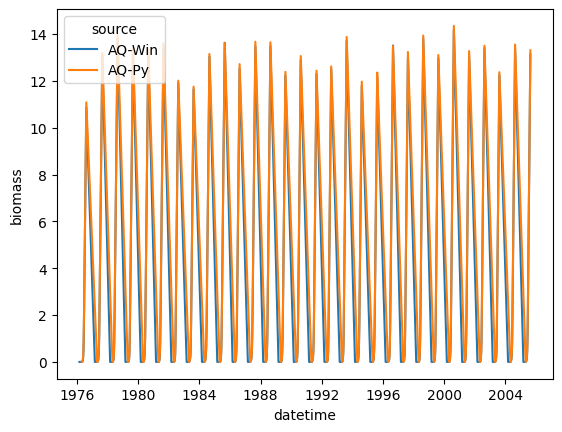

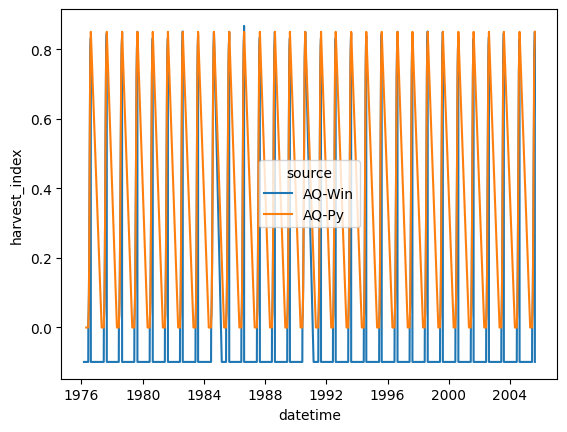

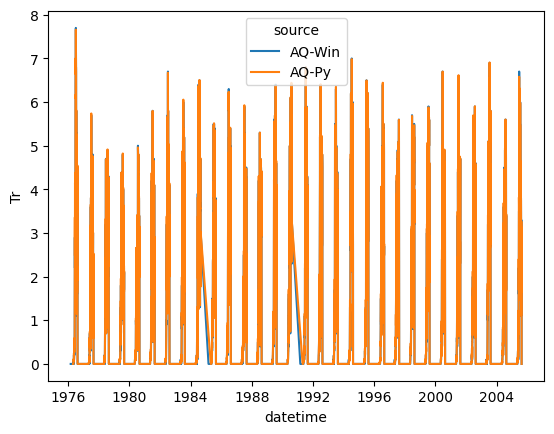

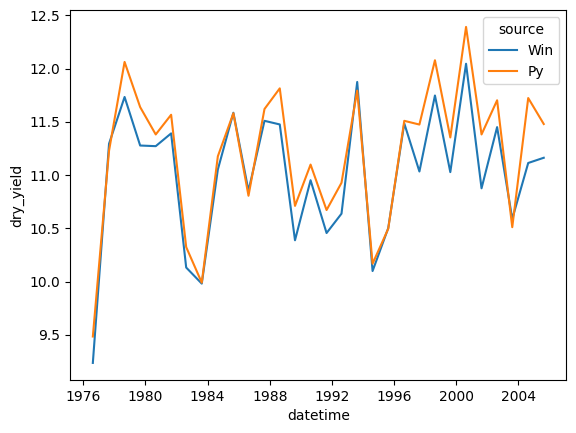

In [ ]:
# create model with IrrMethod= Constant depth
model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loamy_sand,
                      crop=potato,
                      irrigation_management=IrrigationManagement(irrigation_method=5,),
                      initial_water_content=fc,
                      )
                       

model._initialize()

while model._clock_struct.model_is_finished is False:    
    # get depth to apply, RAW = 100%, p_up2=0.6, TAW = 60%/0.6
    depth=get_depth(model,0.6)
    
    model._param_struct.IrrMngt.depth=depth

    model.run_model(initialize_model=False)

run_comparison('Bru_Pot_Irr100RAW2', model)

150% RAW

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_11708\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_11708\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


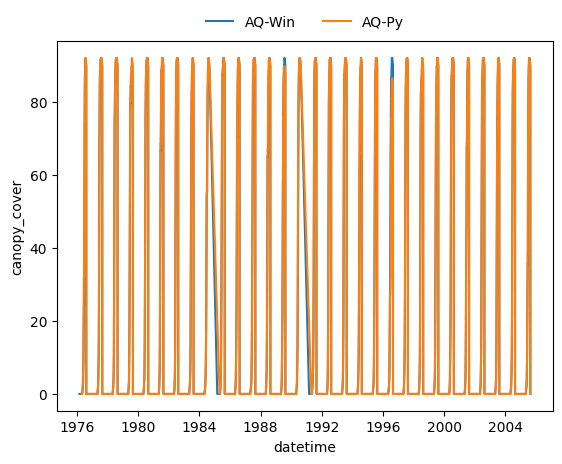

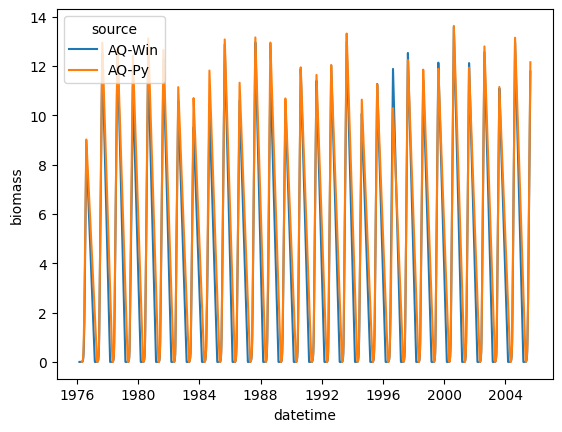

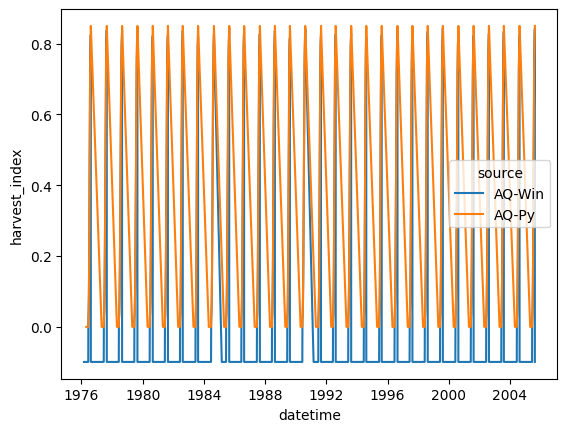

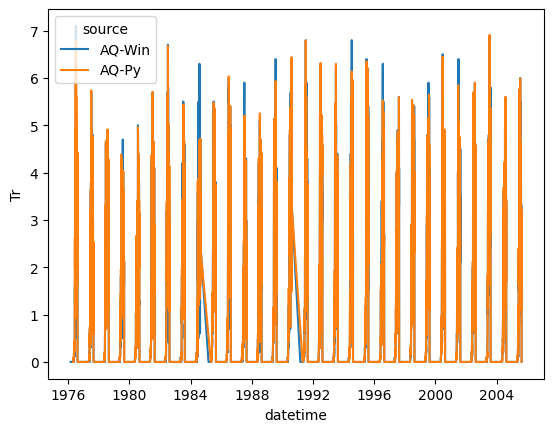

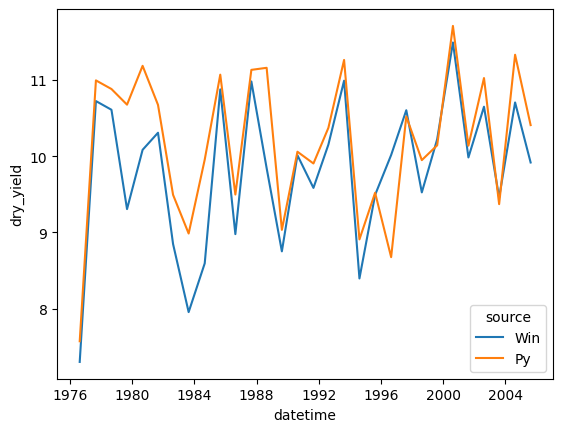

In [ ]:
# create model with IrrMethod= Constant depth
model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loamy_sand,
                      crop=potato,
                      irrigation_management=IrrigationManagement(irrigation_method=5,),
                      initial_water_content=fc,
                      )
                       

model._initialize()

while model._clock_struct.model_is_finished is False:    
    # get depth to apply, RAW = 150%, p_up2=0.6, TAW = 90%,0.9
    depth=get_depth(model,0.9)
    
    model._param_struct.IrrMngt.depth=depth

    model.run_model(initialize_model=False)

run_comparison('Bru_Pot_Irr150RAW2', model)

## 9.6 Climate change impact

Historical:

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_11708\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_11708\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


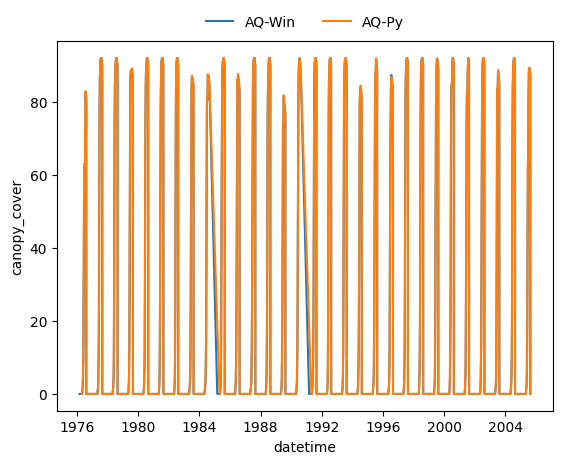

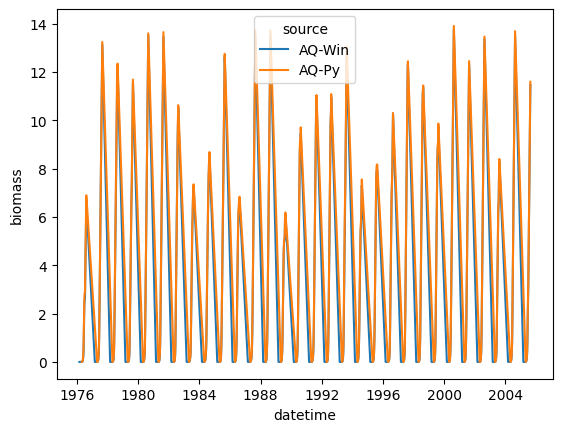

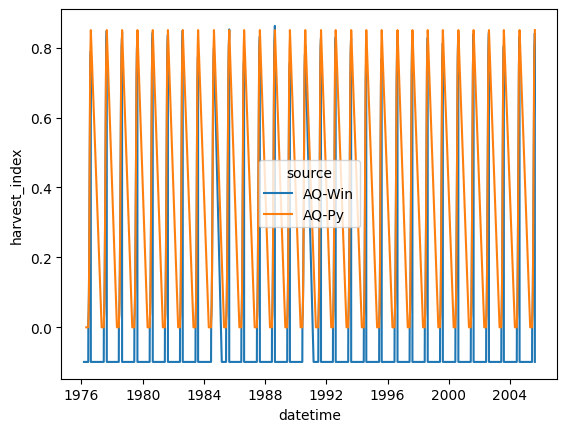

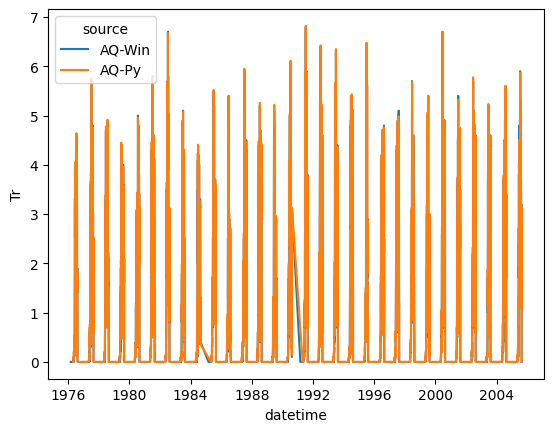

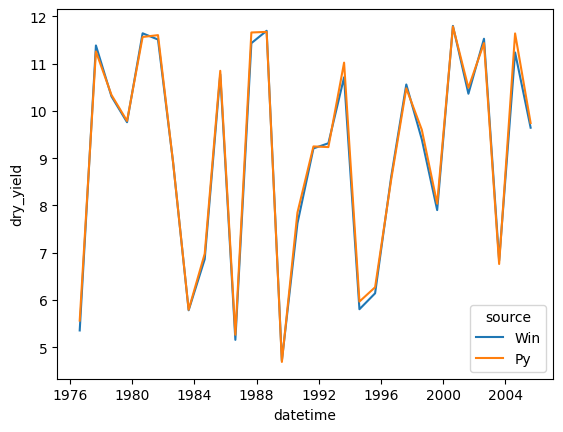

In [ ]:
# Hist climate
filepath=get_filepath('brussels_climate.txt')
brussels_weather = prepare_weather(filepath)

# Local Brussels soil
loam_soil = Soil(soil_type='Loam')

# crops
potato = Crop('PotatoLocalGDD', planting_date='04/25')

# IWC
fc = InitialWaterContent(value=['FC'])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loam_soil,
                      crop=potato,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Bru_Pot_Historical', model)

Future:

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_11708\3773035334.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_11708\3773035334.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


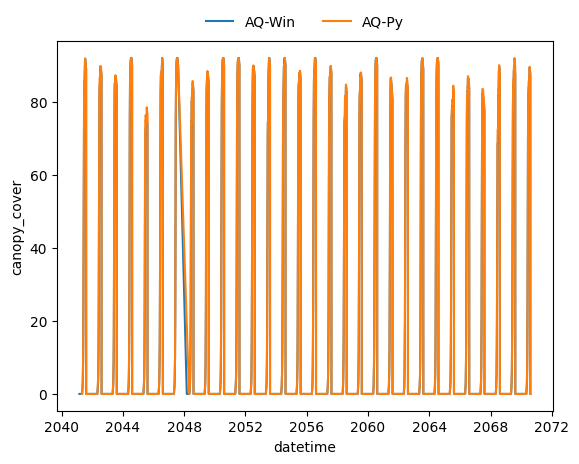

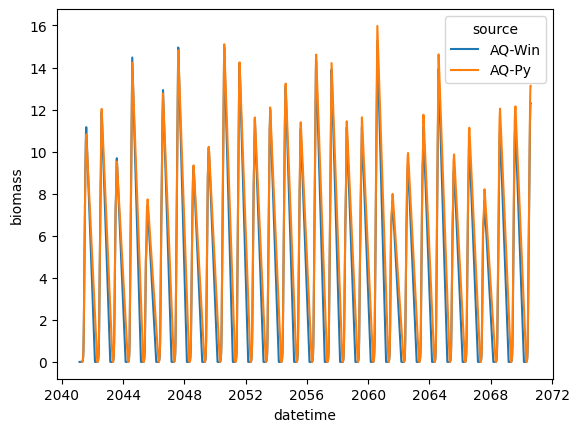

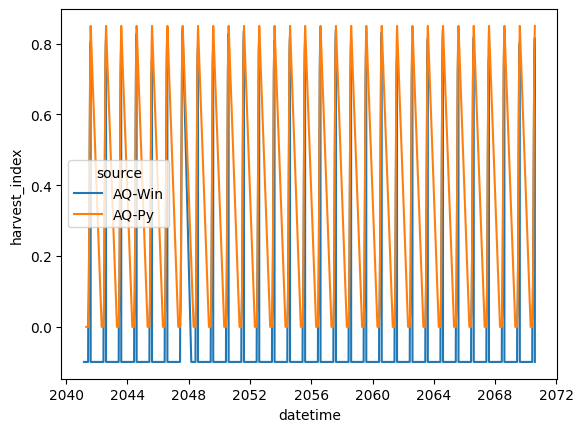

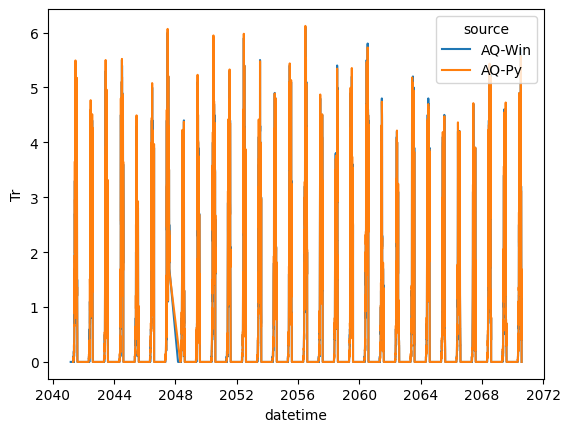

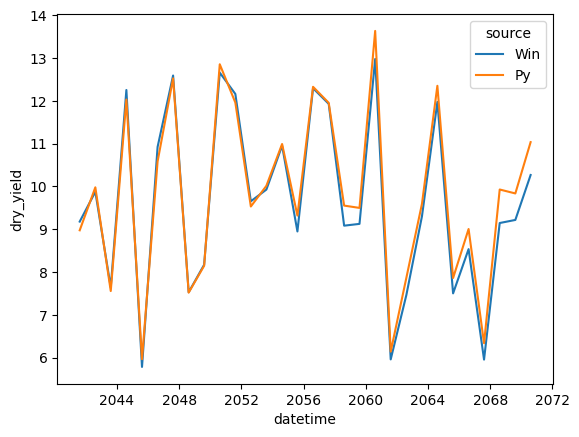

In [ ]:
# Future climate
filepath=get_filepath('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/aquacrop/aquacrop/data/brussels_future.txt')
brussels_future = prepare_weather(filepath)

model = AquaCropModel(sim_start_time=f'{2041}/01/01',
                      sim_end_time=f'{2070}/12/31',
                      weather_df=brussels_future,
                      soil=loam_soil,
                      crop=potato,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Bru_Pot_Future_check', model)

### Convert future climate data from AQ-Win formatting for use in AQ-Py

In [ ]:
future_eto=pd.read_csv('../../AquaCrop-windows/AquaCropV7.1/DATA/BrusselsFuture2py.ETo')
future_temp=pd.read_table('../../AquaCrop-windows/AquaCropV7.1/DATA/BrusselsFuture2py.Tnx')
future_precip=pd.read_table('../../AquaCrop-windows/AquaCropV7.1/DATA/BrusselsFuture2py.PLU')

temp=future_eto.join(future_temp)
future_clim=temp.join(future_precip)
future_clim['datetime']=pd.date_range('2041/01/01','2070/12/31')
future_clim['Year']=pd.DatetimeIndex(future_clim['datetime']).year
future_clim['Month']=pd.DatetimeIndex(future_clim['datetime']).month
future_clim['Day']=pd.DatetimeIndex(future_clim['datetime']).day

future_clim.rename(columns={
    'Tmin (C)' : 'Tmin(C)',
    'TMax (C)' : 'Tmax(C)',
    'Average ETo (mm/day)' : 'Et0(mm)',
    'Total Rain (mm)' : 'Prcp(mm)'
},
inplace=True    
)

print(future_clim)

future_clim.drop('datetime',axis=1,inplace=True)
col_order=['Day', 'Month','Year','Tmin(C)','Tmax(C)','Prcp(mm)','Et0(mm)']
future_clim=future_clim[col_order]

future_clim.to_csv('brussels_future.txt', sep='\t')

print(future_clim)


       Et0(mm)  Tmin(C)  Tmax(C)  Prcp(mm)   datetime  Year  Month  Day
0          0.4      2.5      8.5       0.0 2041-01-01  2041      1    1
1          0.2      0.2      6.3       0.0 2041-01-02  2041      1    2
2          0.6     -1.4      7.9       0.0 2041-01-03  2041      1    3
3          0.5     -3.0      3.9       0.0 2041-01-04  2041      1    4
4          1.1    -10.6      6.1       0.0 2041-01-05  2041      1    5
...        ...      ...      ...       ...        ...   ...    ...  ...
10952      0.6      6.0     11.9       9.7 2070-12-27  2070     12   27
10953      0.4      0.4      8.3       0.0 2070-12-28  2070     12   28
10954      0.4      2.0      6.8       0.0 2070-12-29  2070     12   29
10955      0.3     -0.8      3.7       0.0 2070-12-30  2070     12   30
10956      0.3      3.3      6.6       0.0 2070-12-31  2070     12   31

[10957 rows x 8 columns]
       Day  Month  Year  Tmin(C)  Tmax(C)  Prcp(mm)  Et0(mm)
0        1      1  2041      2.5      8.5       0